# Section 1 Business Understanding

It is real estate data provided by immoscout24.
The data set covers the period from 2007 to 2019 for the 15 largest German cities. Each data point is an apartment offered for rent.
The data set contains 59 features that describe the apartment as well as customer behavior on immoscout24.

**Question 1**:<br>
The rent for the offered apartment has really risen as drastically in the last few years as it is portrayed in the newspaper?

**Question 2**:<br>
Can the apartments be clusters to determine whether there are apartments that have become more expensive than others over the years?

**Question 3**:<br>
How do the clusters change over time?

**Question 4**<br>
How has rent changed in the cities?







# Section 2 Data Understanding combined with data cleaning
A first look at the data showed that a quick visualization is not possible due to various strings in some float columns. For this reason, elements of data cleaning are also carried out in this chapter.


### Import packages

In [1]:
import numpy as np
import pandas as pd
from collections import defaultdict
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from IPython import display
import functions as f 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn import svm
from sklearn.neighbors import KNeighborsRegressor
%matplotlib inline
%config InlineBackend.figure_format='retina'



### Define matplotlib settings

In [13]:
# Define Plot Color
blue = sns.color_palette()[0]
# Plot Style
plt.style.use('seaborn')
# Define Matplotlib Params
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['figure.figsize'] = (12, 9)
mpl.rcParams['axes.labelsize'] = 10
mpl.rcParams['xtick.labelsize'] = 8
mpl.rcParams['ytick.labelsize'] = 8
mpl.rcParams['figure.titlesize'] = 'xx-large' 
mpl.rcParams['axes.titlesize'] = 'large' 

mpl.rcParams['axes.titley'] = 1.03 

### Gather the data

In [2]:
rent = pd.read_csv('data/csv/Campus_city/Campus_WMcitieslabels.csv', low_memory=False)

### Create a copy from the rent dataframe for data cleaning steps

In [29]:
rent_cleaned = rent.copy()

In [30]:
rent_cleaned.shape

(2651885, 59)

In [31]:
rent_cleaned.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2651885 entries, 0 to 2651884
Data columns (total 59 columns):
 #   Column                      Non-Null Count    Dtype  
---  ------                      --------------    -----  
 0   obid                        2651885 non-null  int64  
 1   mietekalt                   2651885 non-null  float64
 2   nebenkosten                 2651885 non-null  object 
 3   heizkosten                  2651885 non-null  object 
 4   baujahr                     1682820 non-null  float64
 5   letzte_modernisierung       2651885 non-null  object 
 6   wohnflaeche                 2651885 non-null  float64
 7   nutzflaeche                 2651885 non-null  object 
 8   etage                       2651885 non-null  object 
 9   anzahletagen                2651885 non-null  object 
 10  zimmeranzahl                2651885 non-null  object 
 11  nebenraeume                 2651885 non-null  object 
 12  schlafzimmer                2651885 non-null  object 
 1

### Change some strings in various columns to numpy nan. 
These strings describe why a value is missing, but in general it is a missing values and will be replaced to np.nan.

In [32]:
nan_values = ['Sonstiges Missing', 'keine Angabe', 'unplausibler Wert geloescht', 'Variable nicht mehr in Einagbemaske vorhanden' ]
rent_cleaned = rent_cleaned.replace(nan_values, np.nan)



### Some Distributions of continous data

<AxesSubplot:xlabel='mietekalt', ylabel='Count'>

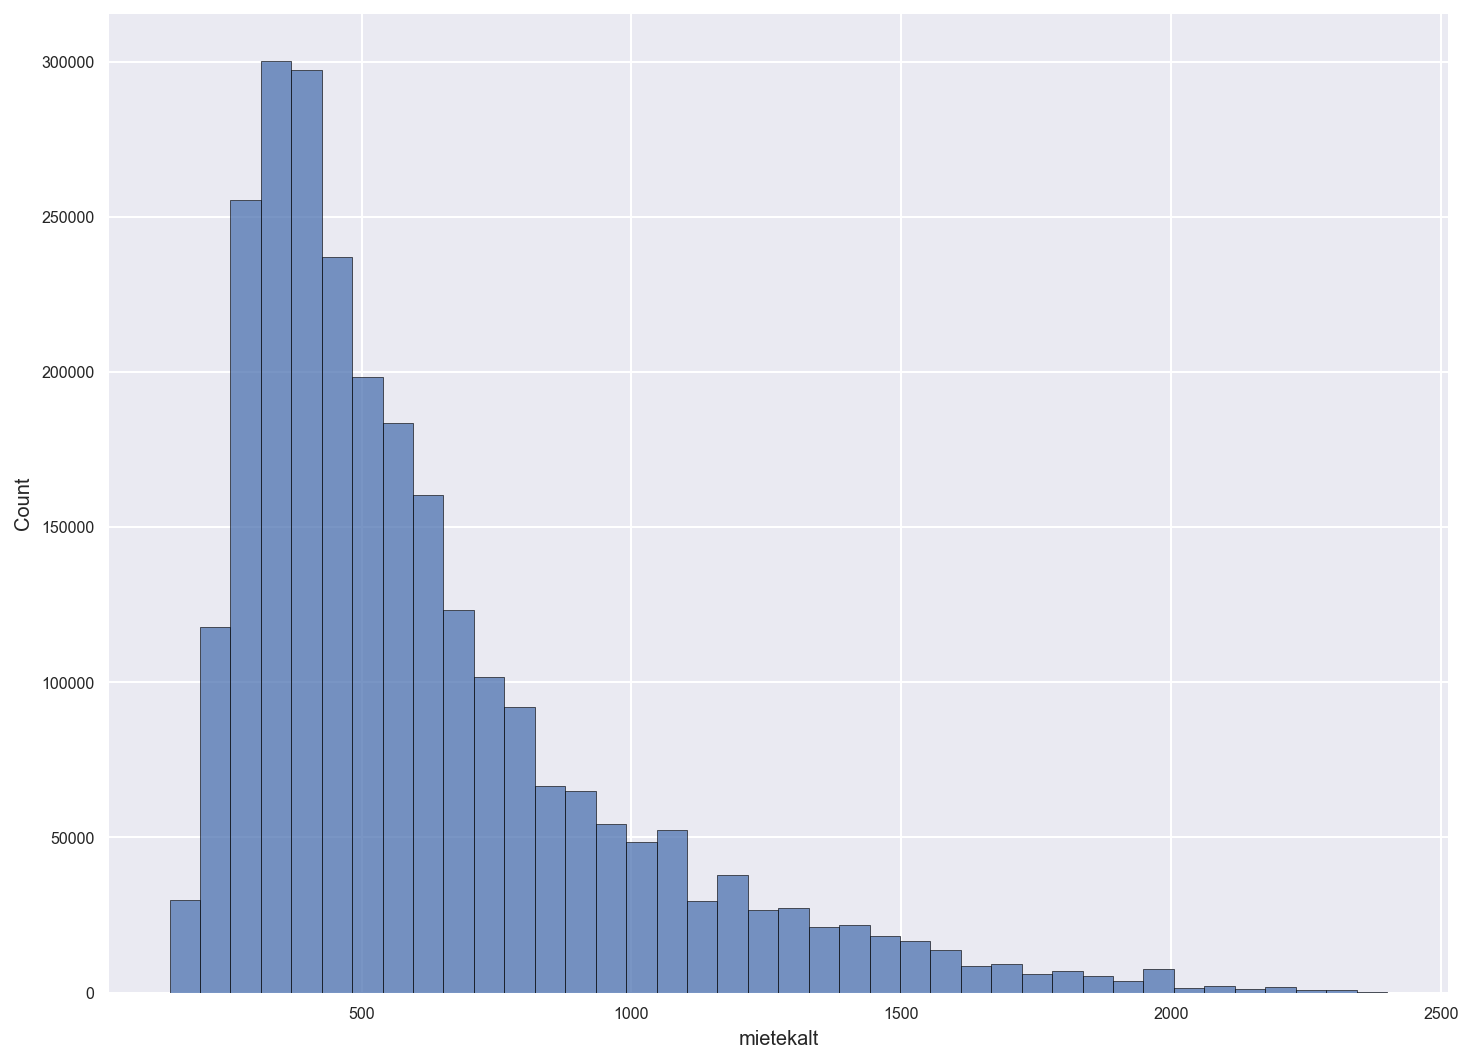

In [34]:
sns.histplot(data=rent_cleaned, x='mietekalt', bins=40)

In [38]:
# The column heizkosten ist object due to previous contained strings
# Change the dtype to float for visualization
rent_cleaned.heizkosten = rent_cleaned.heizkosten.astype(float)


In [40]:
rent_cleaned.heizkosten.describe()

count    824489.000000
mean         72.841451
std          38.893883
min           0.000000
25%          50.000000
50%          68.000000
75%          90.000000
max        1500.000000
Name: heizkosten, dtype: float64

<AxesSubplot:xlabel='heizkosten', ylabel='Count'>

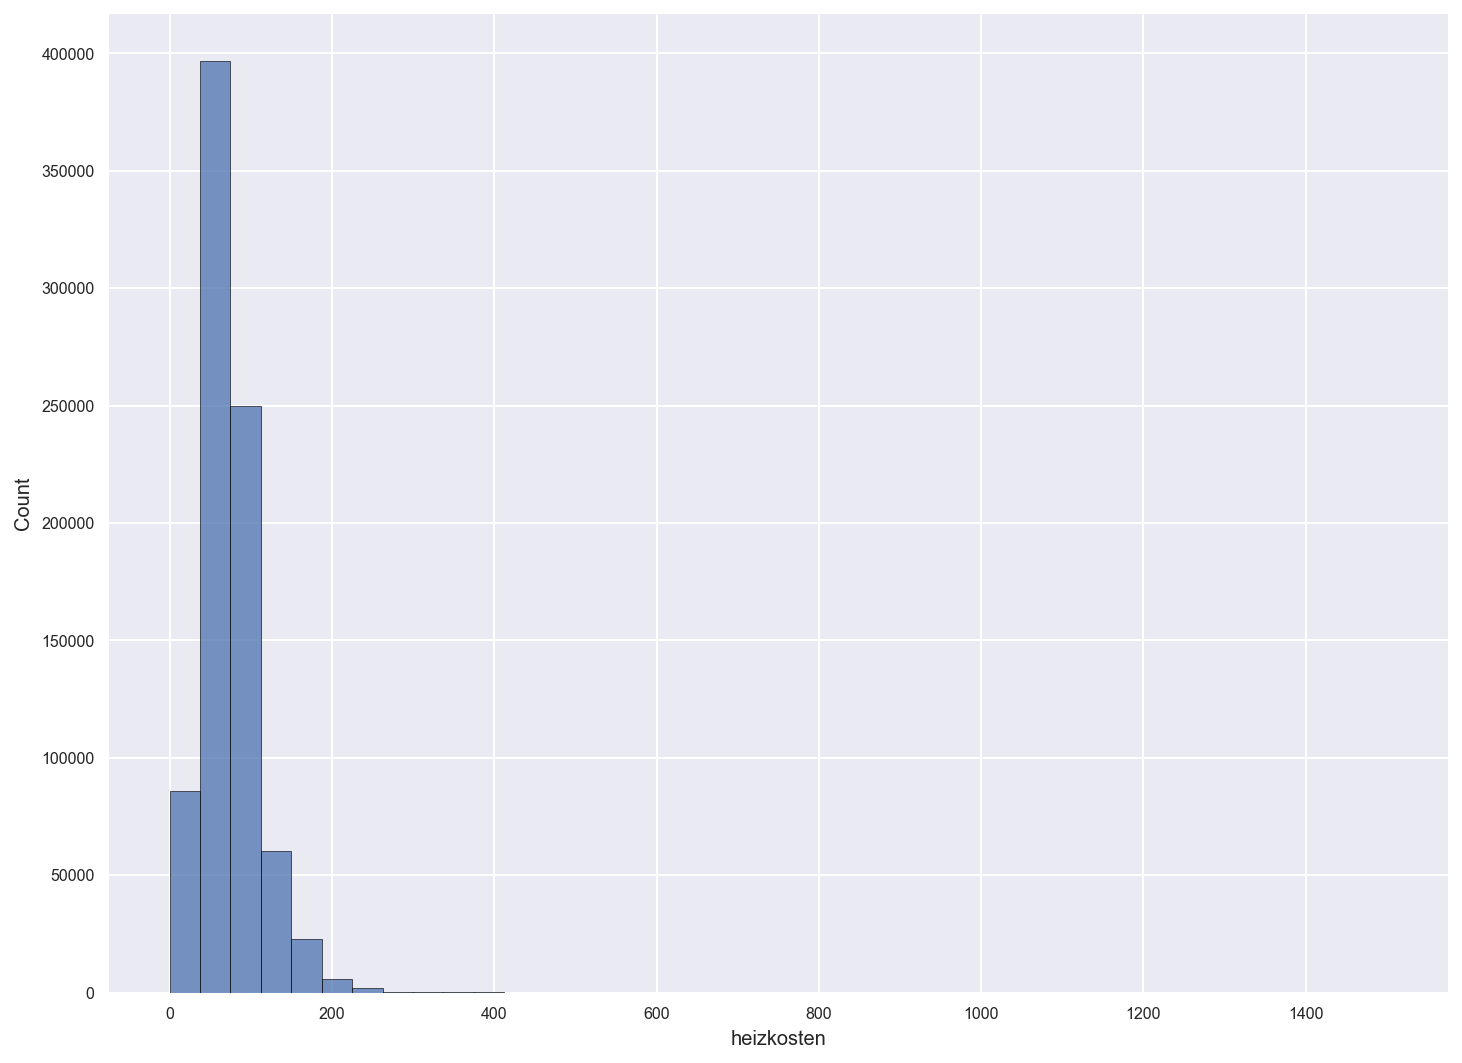

In [37]:
sns.histplot(data=rent_cleaned, x='heizkosten', bins=40)

#### Explanation to heizkosten. 
There are only 824489 values from over 2.6 million datapoints The missing values are more than 50%. Additional there are many outliers as we can see in the histogram.

In [71]:
# The column ev_kenntwert ist object due to previous contained strings
# Change the dtype to float for visualization
rent_cleaned.ev_kennwert = rent_cleaned.ev_kennwert.astype(float)


<AxesSubplot:xlabel='ev_kennwert', ylabel='Count'>

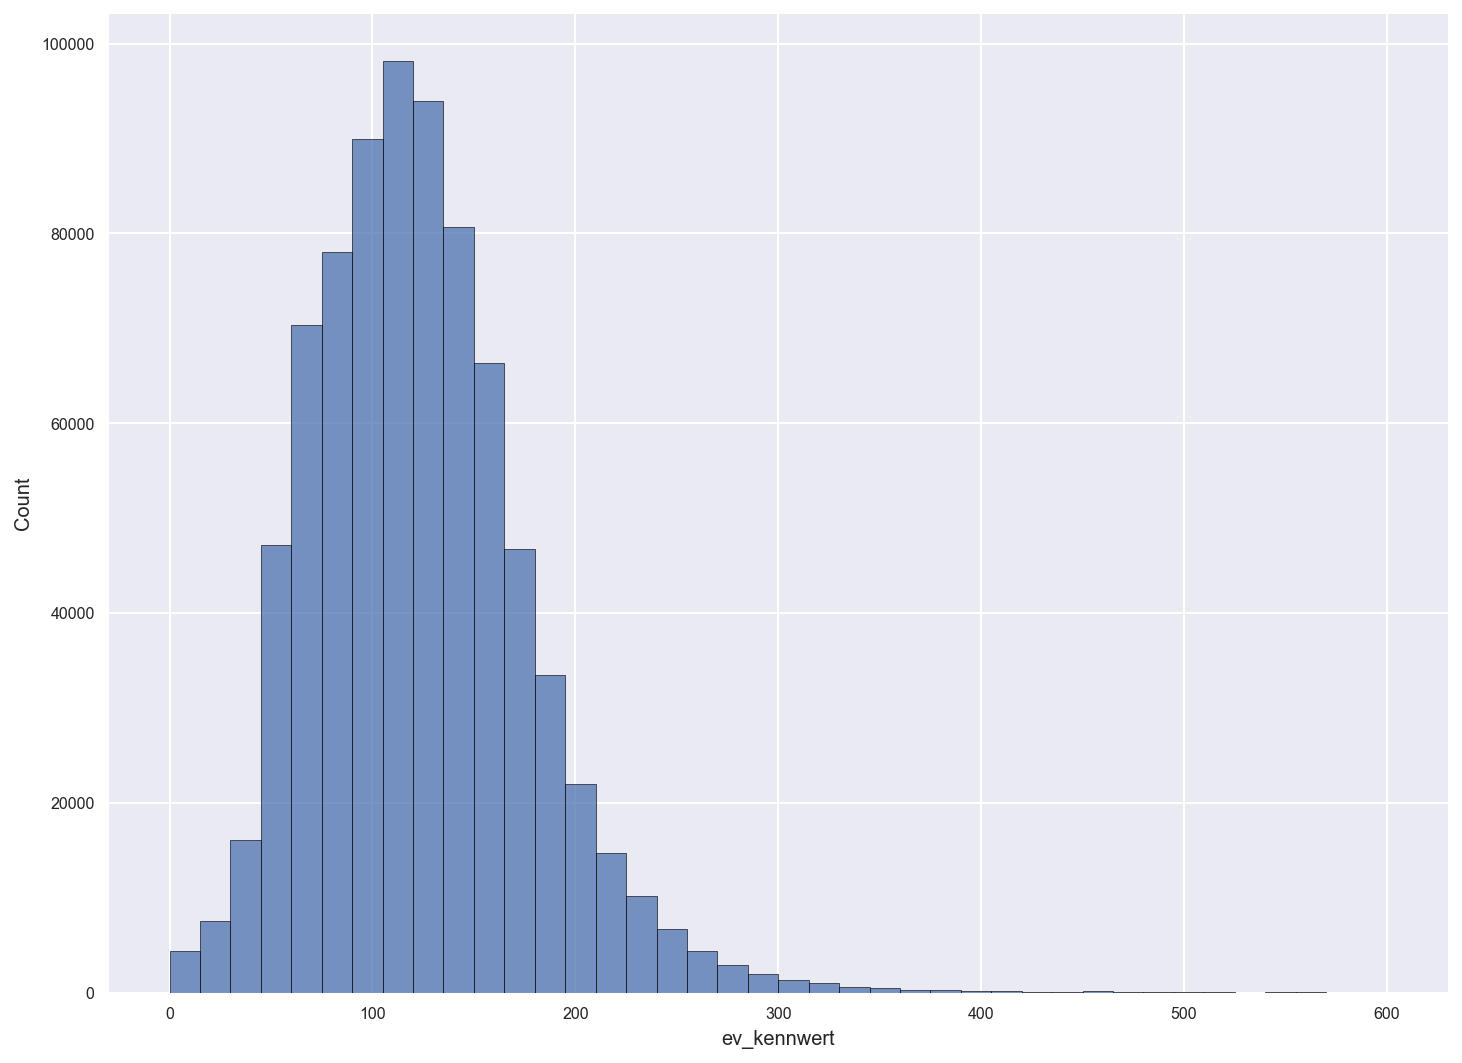

In [72]:
sns.histplot(data=rent_cleaned, x='ev_kennwert', bins=40)

The **ev_kennwert** is not much outliers as the **heizkosten** values. Anyway there are many missing values.

<AxesSubplot:xlabel='laufzeittage', ylabel='Count'>

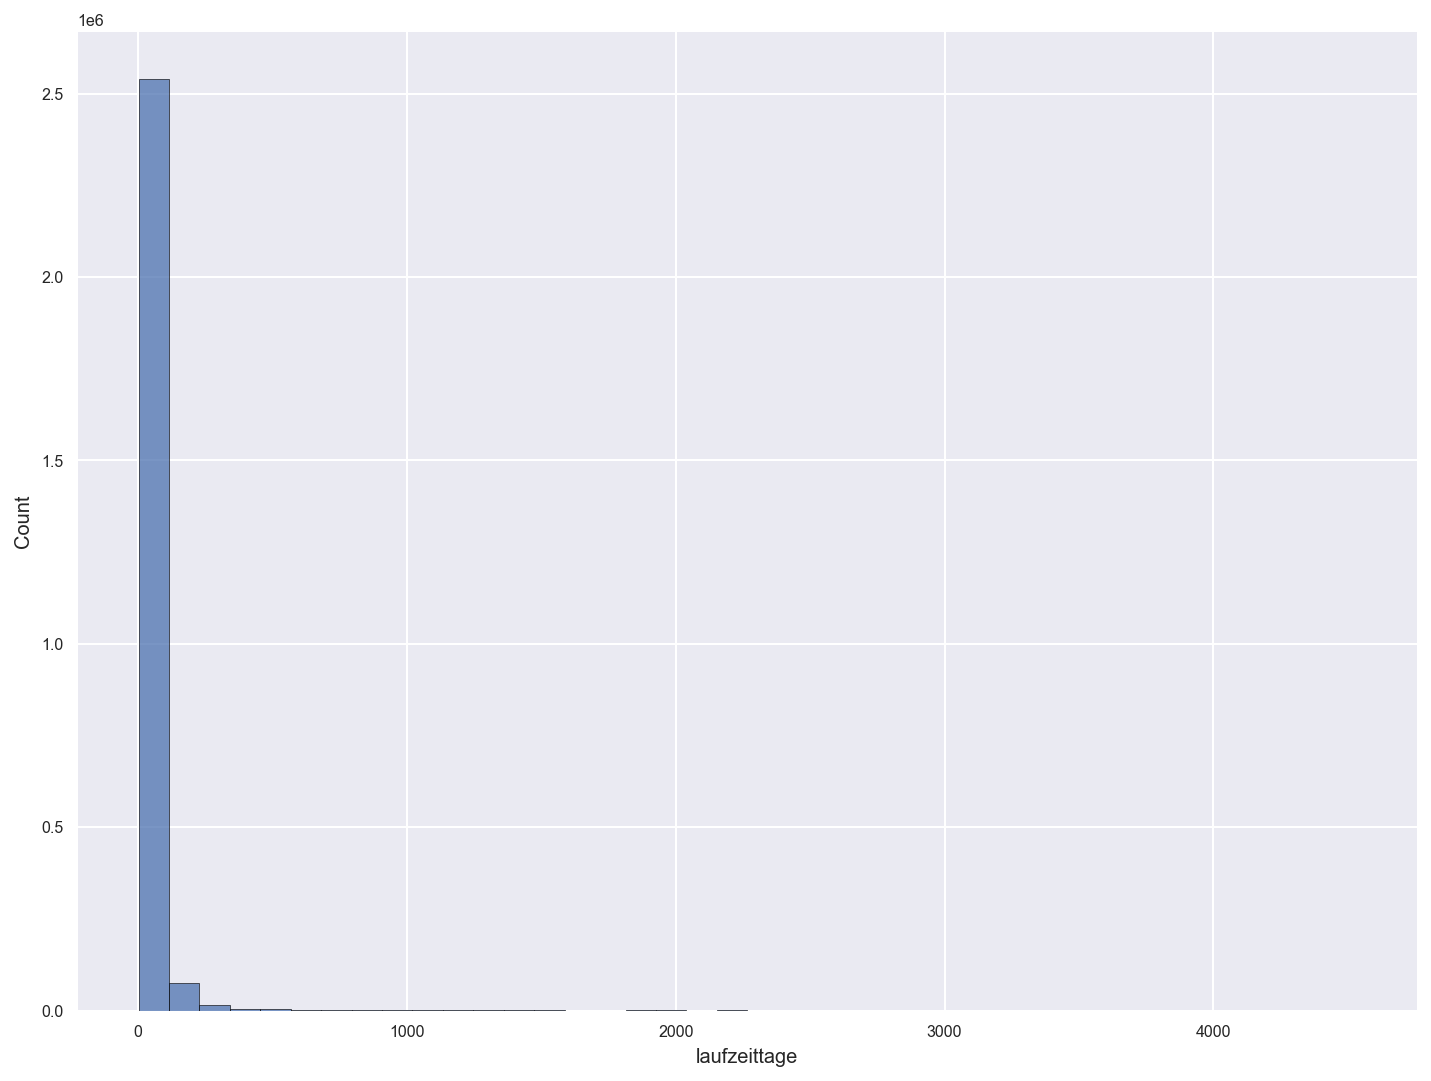

In [91]:
sns.histplot(data=rent_cleaned, x='laufzeittage', bins=40)

<AxesSubplot:xlabel='laufzeittage', ylabel='Count'>

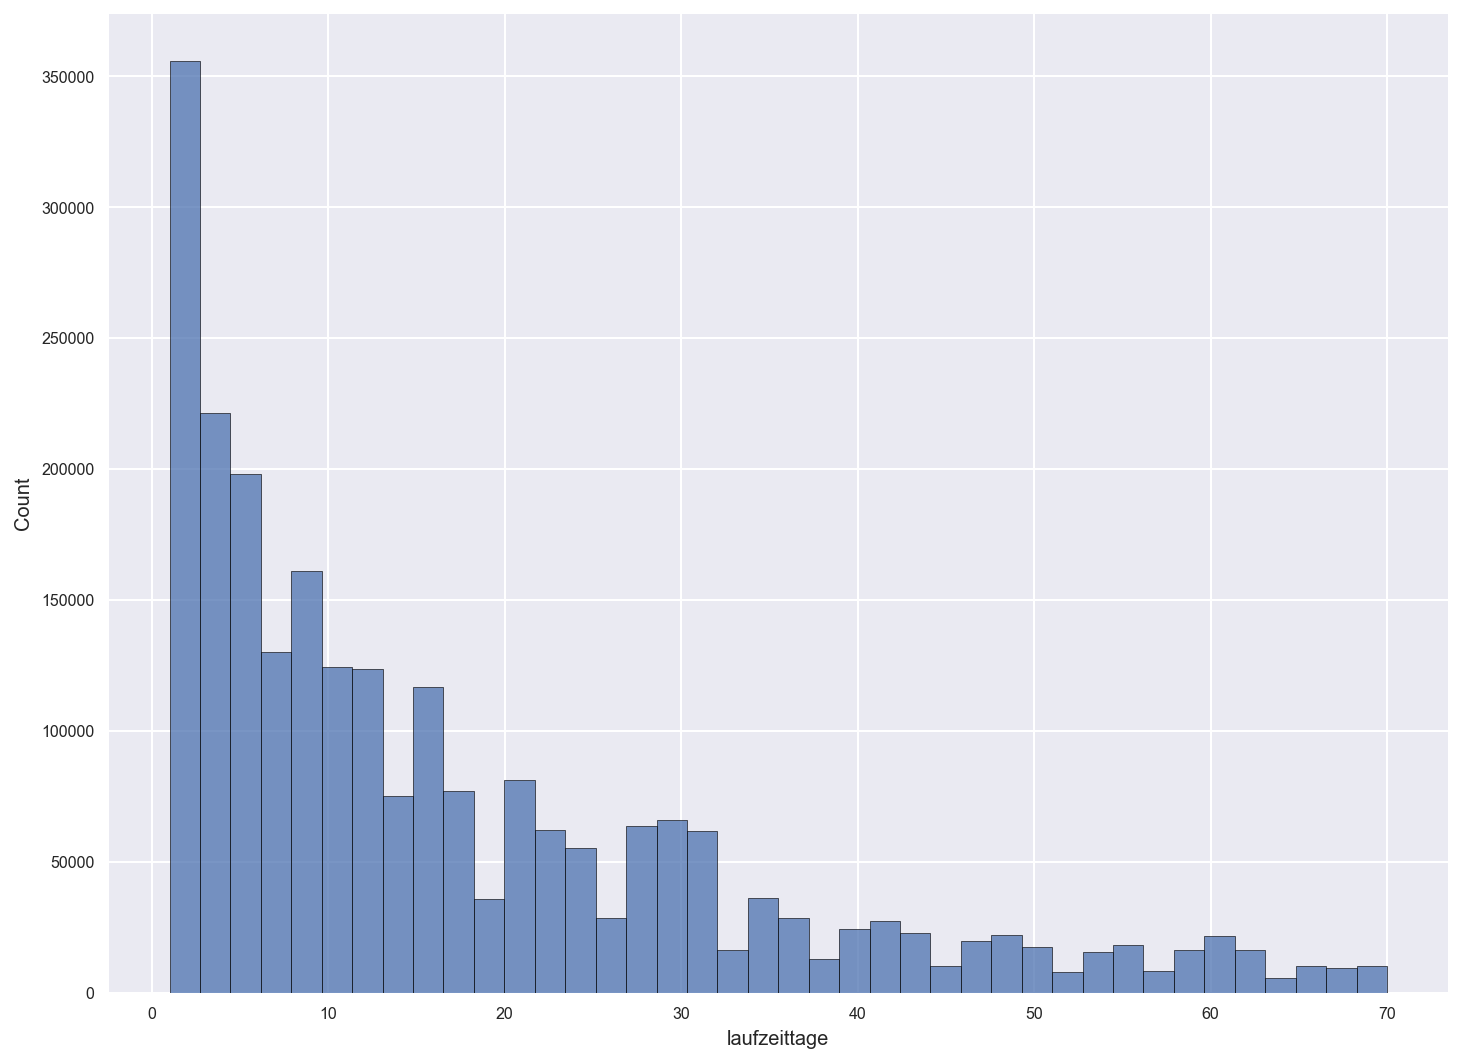

In [92]:
sns.histplot(data=f.remove_outlier(rent_cleaned, ['laufzeittage']), x='laufzeittage', bins=40)

### Count of offers over time

The time of the offer is hidden in the “adat and edat” columns and cannot be interpreted directly. First the column has to be converted into a datetime format. A new column “Year” is then created.

#### Convert object columns to date time

In [42]:
rent_cleaned.adat = pd.to_datetime(rent_cleaned.adat, format='%Ym%m')
rent_cleaned.edat = pd.to_datetime(rent_cleaned.edat, format='%Ym%m')

#### Create year column

In [43]:
# create column year from edat
rent_cleaned['year'] = rent_cleaned.edat.dt.year



<AxesSubplot:xlabel='year', ylabel='count'>

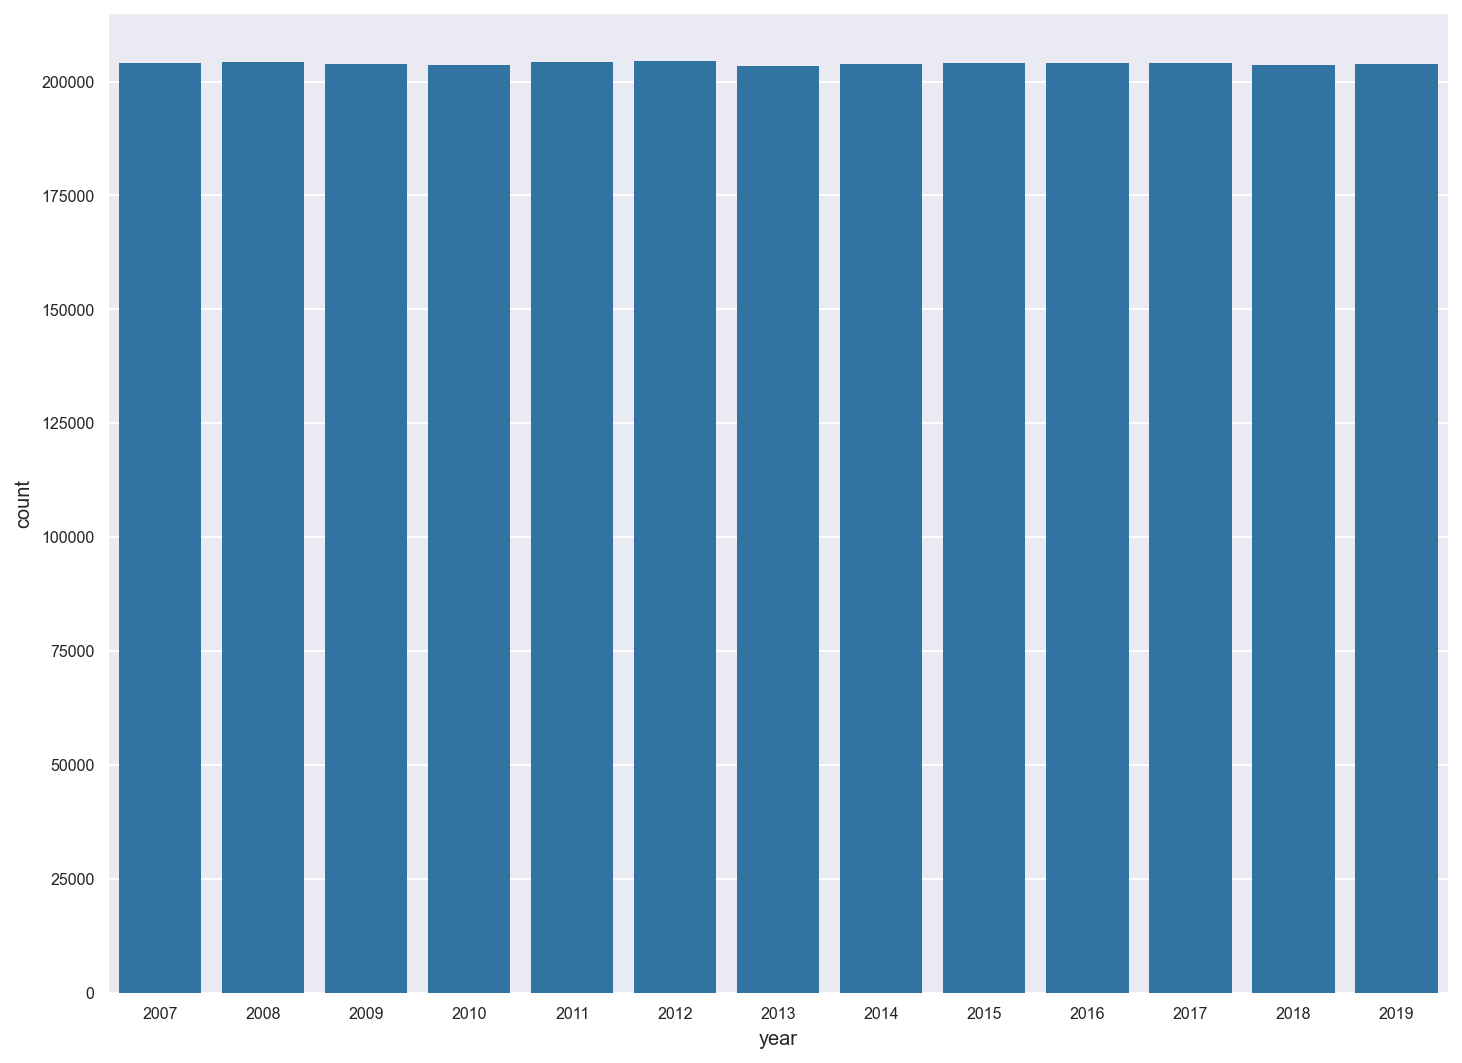

In [45]:
sns.countplot(data=rent_cleaned, x='year', color=blue)

Each year have a similar offer count.

### Count of offers per City

### Map city names to ags_2019 column

In [46]:
ags_map = {11000000: 'Berlin', 6412000: 'Frankfurt', 2000000: 'Hamburg',
 5111000: 'Düsseldorf', 14612000: 'Dresden', 9162000: 'München',
 5315000: 'Köln', 5112000: 'Duisburg', 5913000: 'Dortmund',
 5113000: 'Essen', 4011000: 'Bremen', 3241001: 'Hannover', 
 8111000: 'Stuttgart', 14713000: 'Leipzig', 9564000: 'Nürnberg'
}

In [47]:
rent_cleaned.loc[:,'City'] = rent_cleaned.ags2019.map(ags_map)

<AxesSubplot:xlabel='City', ylabel='count'>

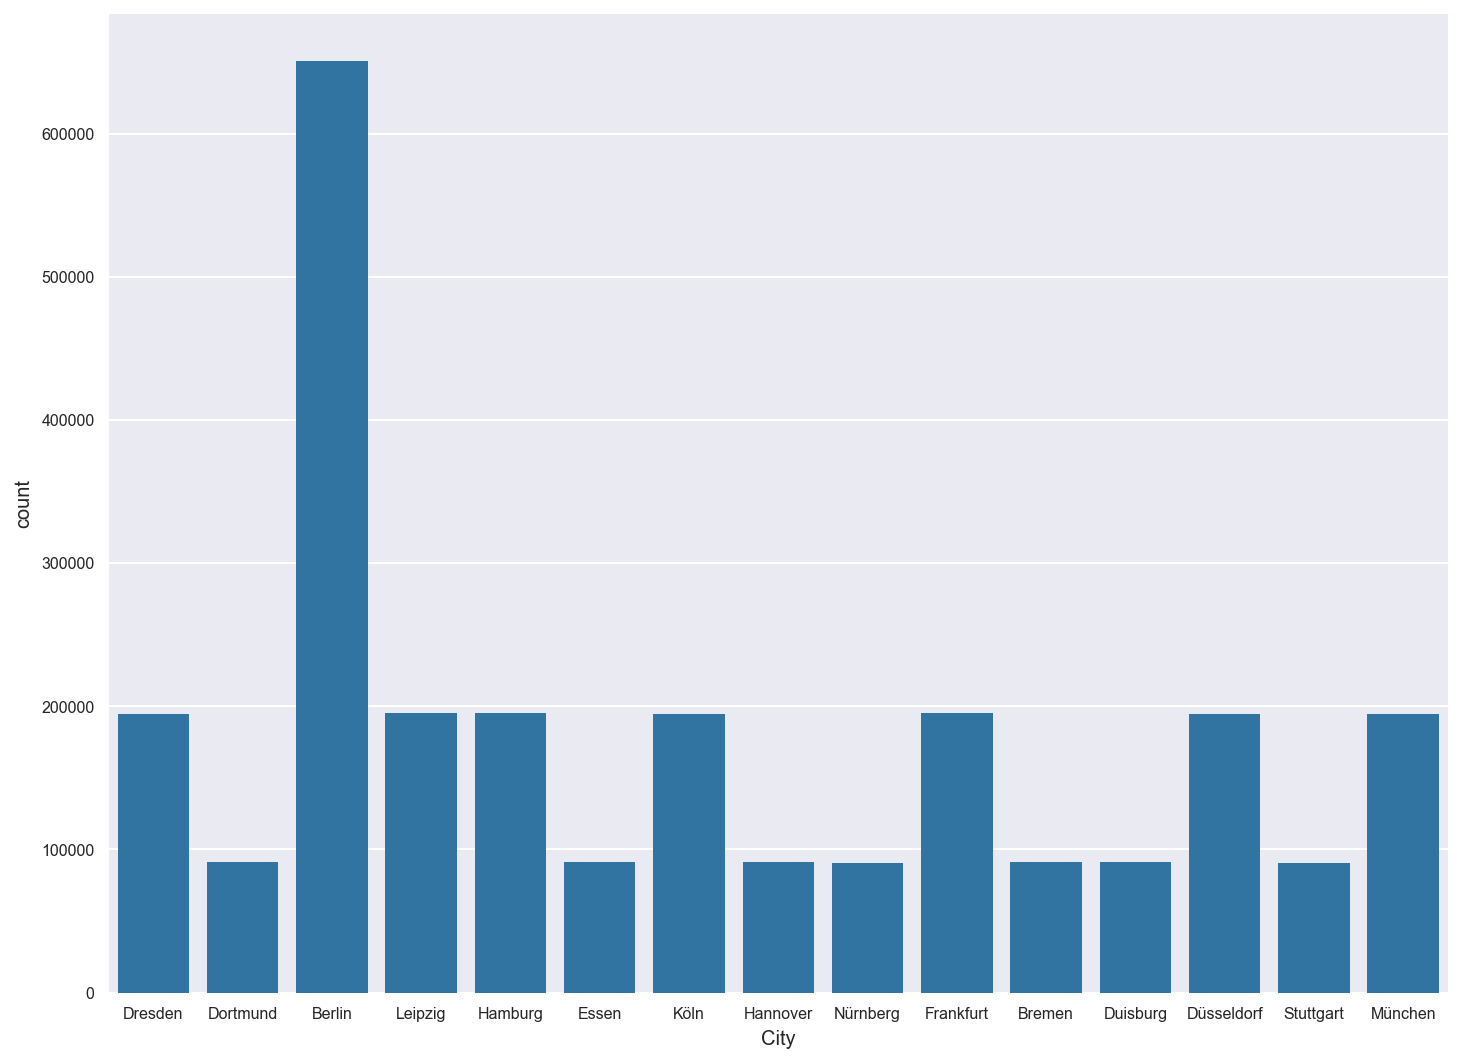

In [50]:
sns.countplot(data=rent_cleaned, x='City', color=blue)

The offer count oc different cities depends a lttlebit on the size of the city. But nut exactly. Some cities with 100000 counts are smaller the cities with 200000 counts. 

### Count of offers per City and year

In [62]:
city_year_count = rent_cleaned.groupby(['City', 'year']).size().reset_index(name='count') 

In [63]:
city_year_count

,City,year,count
0,Berlin,2007,49845
1,Berlin,2008,50221
2,Berlin,2009,50051
3,Berlin,2010,49860
4,Berlin,2011,50150
...,...,...,...
190,Stuttgart,2015,6924
191,Stuttgart,2016,6921
192,Stuttgart,2017,7020
193,Stuttgart,2018,6960


<AxesSubplot:xlabel='year', ylabel='count'>

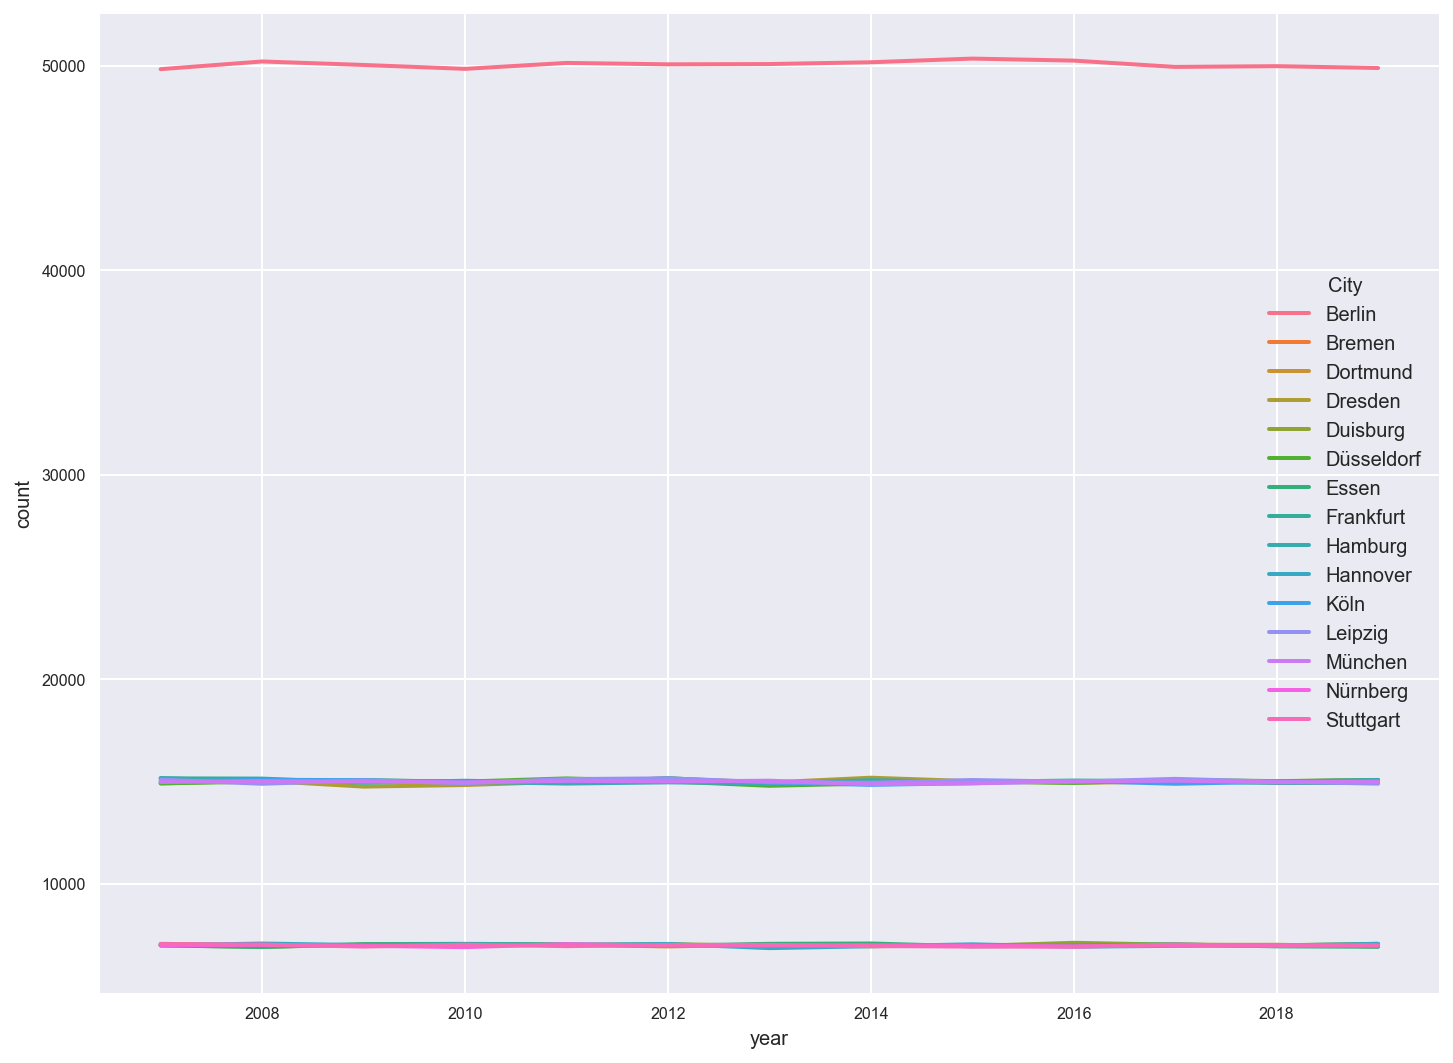

In [66]:
sns.lineplot(data=city_year_count, x='year', y='count', hue='City')

As we can see the different cities have the same size over the years.

### Analyse some more columns regarding value counts

#### Baujahr

In [69]:
rent_cleaned.baujahr.value_counts(dropna=False)

NaN       969065
1900.0    108472
1910.0     45293
1960.0     45095
1996.0     32926
           ...  
1732.0         1
1734.0         1
1692.0         1
1738.0         1
1686.0         1
Name: baujahr, Length: 369, dtype: int64

There are about 1 million missing values. The highest building construction was in 1900. 

#### Energieausweis

In [74]:
rent_cleaned.energieausweistyp.value_counts(dropna=False)

NaN                          1828023
Energieverbrauchskennwert     534310
Endenergiebedarf              289552
Name: energieausweistyp, dtype: int64

There are about 1.8 million missing values. 

In [80]:
missing_value_count = rent_cleaned.isnull().sum().reset_index(name='nan_count').sort_values(by='nan_count', ascending=False)

In [81]:
missing_value_count

,index,nan_count
11,nebenraeume,2651703
32,rollstuhlgerecht,2561504
35,energieeffizienzklasse,2560651
31,parkplatz,2316022
5,letzte_modernisierung,2095283
...,...,...
17,click_schnellkontakte,0
16,hits,0
15,laufzeittage,0
6,wohnflaeche,0


<AxesSubplot:xlabel='nan_count', ylabel='index'>

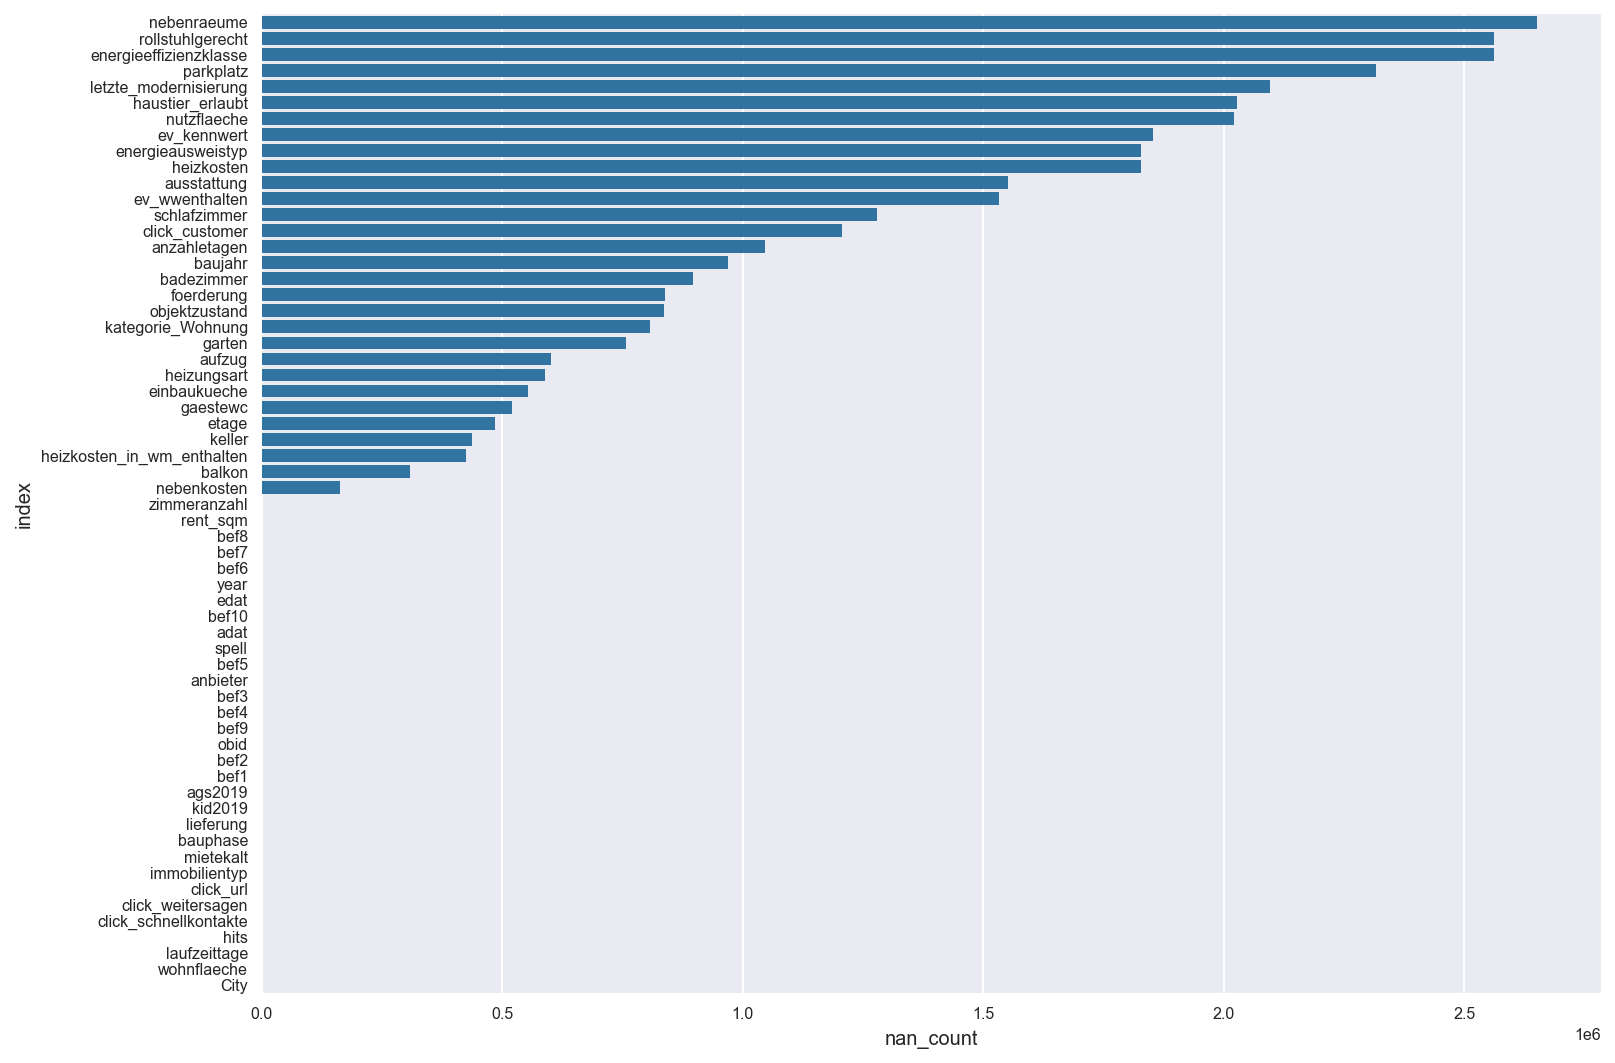

In [84]:
sns.barplot(data=missing_value_count, x='nan_count', y='index', color=blue)

In [98]:
rent_cleaned.laufzeittage.value_counts()

1       237587
7       130130
2       118380
3       118147
6       103627
         ...  
1293         1
2999         1
1657         1
2267         1
1268         1
Name: laufzeittage, Length: 2224, dtype: int64

In [103]:
laufzeittage_city = rent_cleaned.groupby(['City']).laufzeittage.mean().reset_index(name='laufzeittage_mean').sort_values(by='laufzeittage_mean', ascending=False)

<AxesSubplot:xlabel='laufzeittage_mean', ylabel='City'>

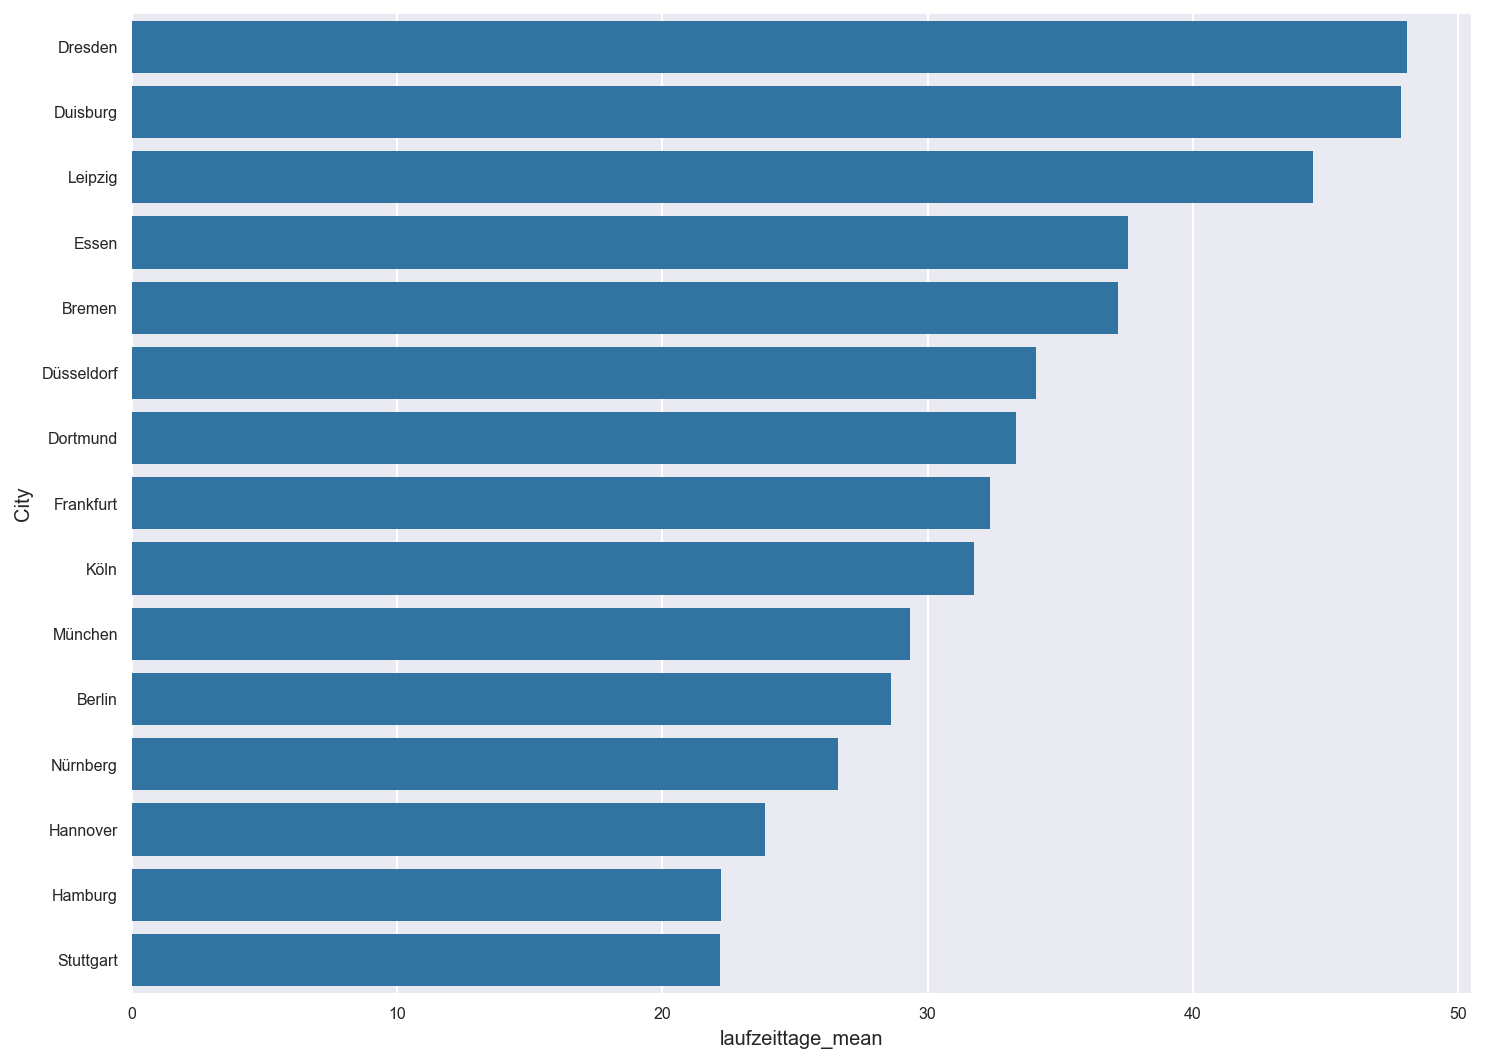

In [104]:
sns.barplot(data=laufzeittage_city, x='laufzeittage_mean', y='City', color=blue)

In [112]:
laufzeittage_year = rent_cleaned.groupby(['year']).laufzeittage.mean().reset_index(name='laufzeittage_mean').sort_values(by='year', ascending=False)

<AxesSubplot:xlabel='year', ylabel='laufzeittage_mean'>

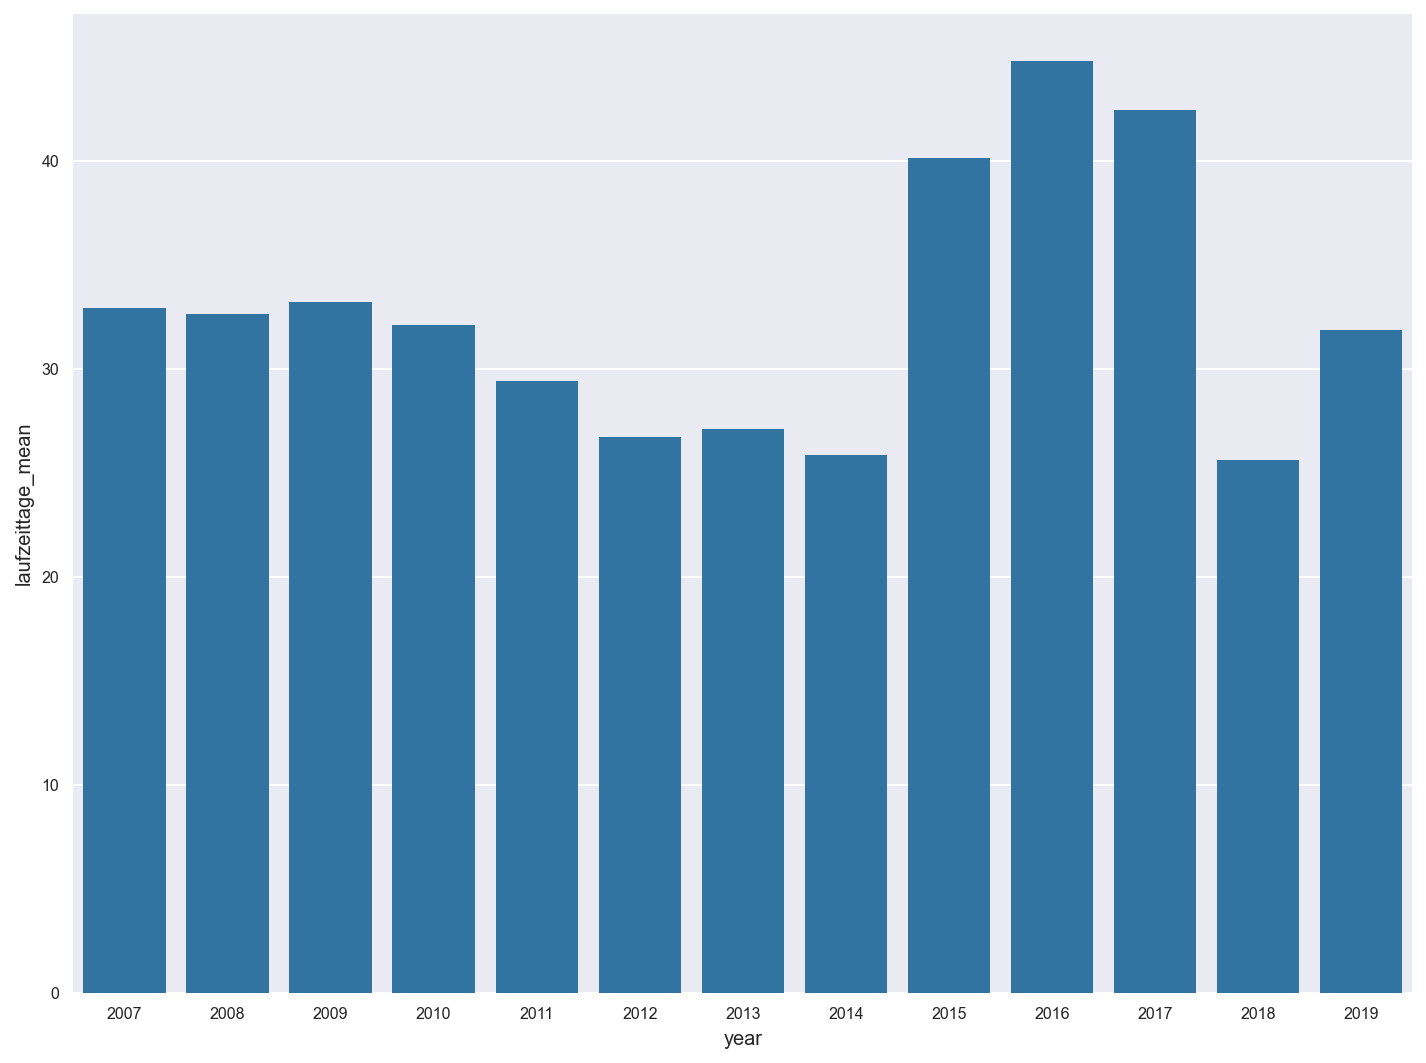

In [111]:
sns.barplot(data=laufzeittage_year, y='laufzeittage_mean', x='year', color=blue)

In [114]:
laufzeittage_city_year = rent_cleaned.groupby(['City', 'year']).laufzeittage.mean().reset_index(name='laufzeittage_mean').sort_values(by='year', ascending=False). \
pivot(index='City', columns='year', values='laufzeittage_mean')

In [115]:
laufzeittage_city_year

year,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
City,,,,,,,,,,,,,
Berlin,33.933755,35.808885,33.381811,30.287826,26.019741,25.425283,25.020461,21.295598,35.193340,37.901222,26.132239,19.443471,22.198629
Bremen,21.457465,23.328386,24.799771,27.040694,23.298113,26.325043,25.522900,31.342861,53.945473,84.824479,82.104309,25.511648,33.723959
Dortmund,22.429523,27.834407,37.663379,39.025543,34.161323,31.645650,32.127187,28.777570,32.504432,31.230649,42.340656,25.181546,48.424146
Dresden,38.597370,37.169737,40.038167,47.756390,30.751401,29.719245,24.932651,24.677511,75.486513,110.929624,100.153518,34.818388,30.839337
Duisburg,58.893961,57.608513,59.273206,53.119674,50.868579,48.495527,48.946470,30.064815,39.532537,44.358650,47.970060,41.275304,42.111190
Düsseldorf,33.146643,31.492763,32.385867,33.501400,29.383671,27.256380,26.515483,30.051077,42.597160,46.669591,46.037793,24.188907,39.821090
Essen,43.210368,40.511011,48.388502,37.681213,38.791578,37.185435,40.933135,30.463180,37.988325,30.822990,37.139608,31.141889,34.002169
Frankfurt,24.088431,26.343746,24.081347,26.420097,39.449869,21.474909,23.091459,23.363170,45.512846,48.791373,50.538231,27.547239,40.162292
Hamburg,27.140927,24.078150,21.241024,20.511550,18.442177,18.017183,19.424547,21.554862,27.518291,26.424521,23.300226,20.037143,21.192611


<AxesSubplot:xlabel='year', ylabel='City'>

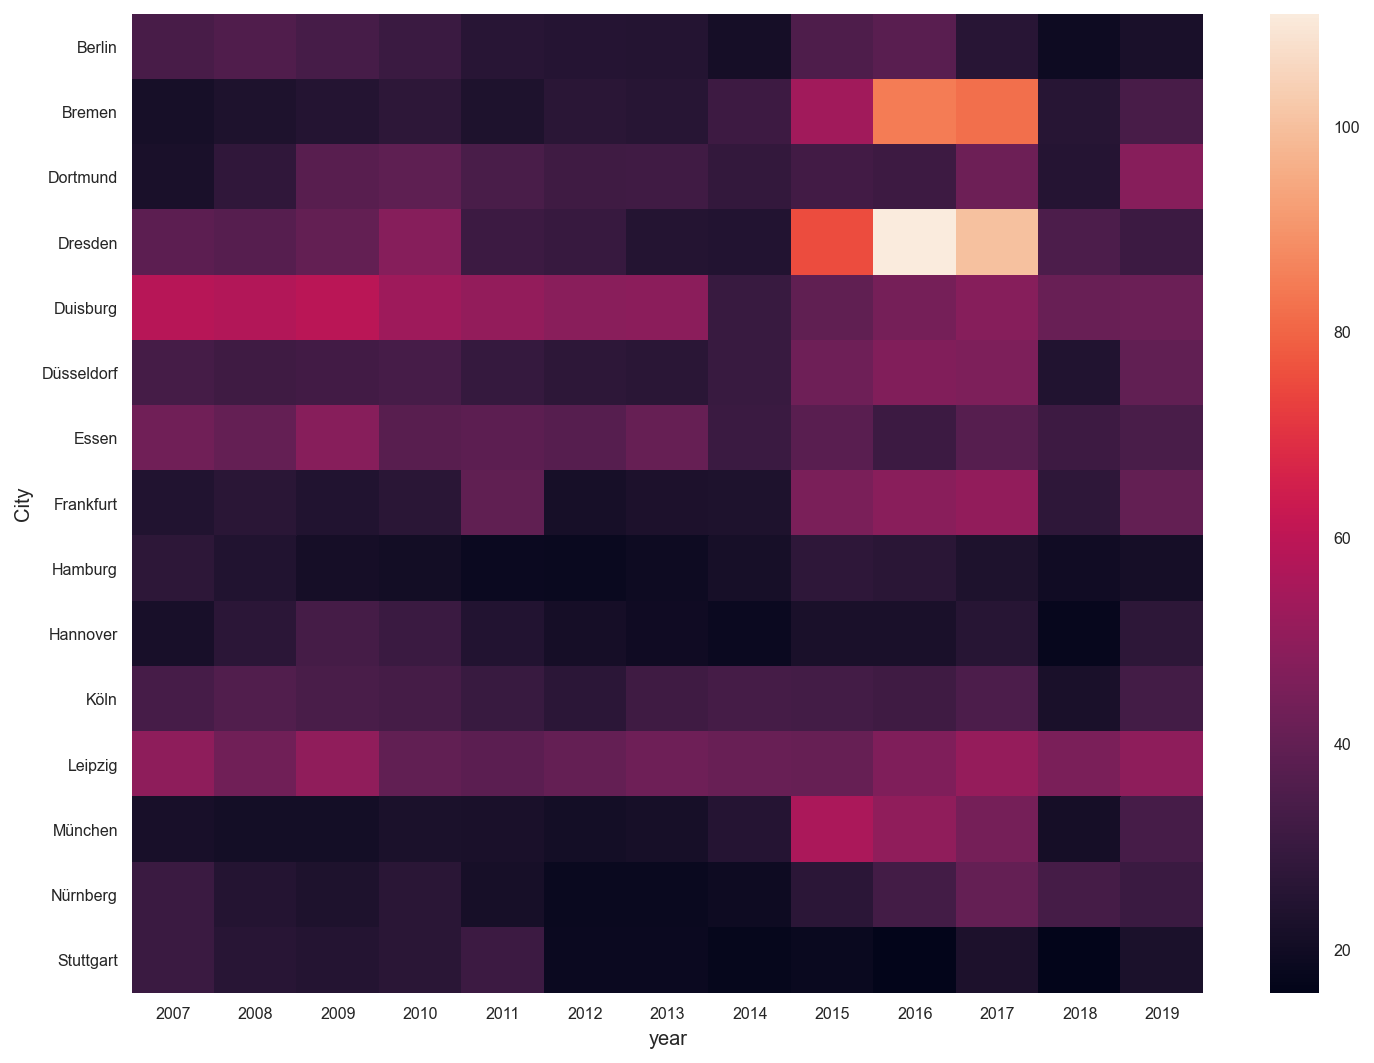

In [117]:
sns.heatmap(data=laufzeittage_city_year)

# Section 3 Data Cleaning
There is already a lot a data cleaning done in the “Data Understanding“ Section.
In this section I will finish the data cleaning.

### Drop columns nebenraeume because there are only 182 non-null values

In [118]:
rent_cleaned = rent_cleaned.drop(columns=['nebenraeume'])

### Replace -9 in anbieter column to np.nan

In [119]:
rent_cleaned.anbieter = rent_cleaned.anbieter.replace('-9', np.nan)


### Drop immonbilientyp column it is only one value and lieferung column it is only delivery data from Immoscout to rwi-essen


In [120]:
rent_cleaned = rent_cleaned.drop(columns=['immobilientyp', 'lieferung'])

### Drop columns without information

In [121]:
drop_columns = ['bauphase', 'bef6', 'bef7', 'bef8', 'bef9', 'bef10']
rent_cleaned = rent_cleaned.drop(columns=drop_columns)


### Replace -9 in obejct columns to np.nan

In [122]:
firing_columns=['bef1', 'bef2', 'bef3', 'bef4', 'bef5']

In [123]:
rent_cleaned[firing_columns] = rent_cleaned[firing_columns].replace('-9', np.nan)

### Create dummy columns from Firing Type columns

In [124]:
# Define Set for unique firing types
firingTypes = set()

# loop over bef1 - bef5 columns
for col in firing_columns:
    # loop over firing types in bef
    for firing in rent_cleaned[col].value_counts().index:
        firingTypes.add(firing)
# Output of firing types
firingTypes


{'Bioenergie',
 'Elektro',
 'Erdgas leicht',
 'Erdgas schwer',
 'Erdwärme',
 'Fernwärme',
 'Flüssiggas',
 'Gas',
 'Heizdampf-Fernwärme',
 'Holz',
 'Holzschnitzel',
 'Kohle',
 'Koks',
 'Nahwärme',
 'Pellets',
 'Solarenergie',
 'Wasserenergie',
 'Windenergie',
 'Wärmezufuhr',
 'keine Information',
 'kombinierte Bio Energie',
 'kombinierte Fossilkraftstoffe',
 'kombinierte erneuerbare Energie',
 'kombinierte regenerative Energie',
 'thermische Umweltenergie',
 'Öl'}

In [125]:
# Create a bef df for each bef column with firing types dummies
# reindex bef df that each df has same columns
# fillna each dummy column with 0 and set astype int
bef = []
for col in firing_columns:
    bef.append(pd.get_dummies(rent_cleaned[col]).reindex(columns=firingTypes).fillna(0).astype(int))


In [126]:
# Sum all bef df and join this to rent_cleaned df
rent_cleaned = rent_cleaned.join(sum(bef))

In [127]:
# Drop no longer used bef columns
rent_cleaned = rent_cleaned.drop(columns=firing_columns)

In [128]:
rent_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2651885 entries, 0 to 2651884
Data columns (total 73 columns):
 #   Column                            Dtype         
---  ------                            -----         
 0   obid                              int64         
 1   mietekalt                         float64       
 2   nebenkosten                       object        
 3   heizkosten                        float64       
 4   baujahr                           float64       
 5   letzte_modernisierung             object        
 6   wohnflaeche                       float64       
 7   nutzflaeche                       object        
 8   etage                             object        
 9   anzahletagen                      object        
 10  zimmeranzahl                      object        
 11  schlafzimmer                      object        
 12  badezimmer                        object        
 13  ev_kennwert                       float64       
 14  laufzeittage      

### Counts on different firing types

#### How many datapoints have no informations?

In [137]:
rent_cleaned.iloc[:,47:73].sum(axis=1).reset_index(name='null_counts').groupby('null_counts').size()

null_counts
0    2507559
1     141396
2       2873
3         45
4         12
dtype: int64

Over 2.5 million offers have no firing type entered. We can forget these columns. Much effort for nothing.

### Convert object columns to bool

In [138]:
bool_columns = ['aufzug', 'balkon', 'einbaukueche', 'ev_wwenthalten',
       'foerderung', 'gaestewc', 'garten', 'heizkosten_in_wm_enthalten',
       'keller', 'parkplatz', 'rollstuhlgerecht', 
       'haustier_erlaubt']

rent_cleaned[bool_columns] = rent_cleaned[bool_columns].apply(lambda x: x.map({'Ja':True, 'Nein':False}).astype(bool))

### Convert object columns to numeric

In [140]:
float_columns = ['nebenkosten', 'heizkosten', 'letzte_modernisierung', 'nutzflaeche',
       'etage', 'anzahletagen', 'zimmeranzahl', 'schlafzimmer',
       'badezimmer', 'ev_kennwert', 'click_customer']
rent_cleaned[float_columns] = rent_cleaned[float_columns].astype(float)


### Pickle the dataframe


In [141]:

rent_cleaned.to_pickle('data/rent_cleaned.pkl')

# Section 4: Data Modeling

In [188]:
df = pd.read_pickle('data/rent_cleaned.pkl')

## Clustering of the offers

In [146]:
# Define the columns for the clustering
columns = ['mietekalt', 'wohnflaeche',
       'aufzug', 'balkon',
       'einbaukueche', 'ev_wwenthalten', 'foerderung', 'gaestewc', 'garten',
       'heizkosten_in_wm_enthalten', 'keller', 'parkplatz', 'rollstuhlgerecht',
       'ausstattung', 'energieausweistyp',
       'haustier_erlaubt', 'heizungsart', 'kategorie_Wohnung', 'objektzustand',
       'anbieter', 'rent_sqm',
       'Wärmezufuhr', 'Erdgas leicht', 'Erdgas schwer',
       'keine Information', 'Windenergie', 'Pellets', 'Solarenergie', 'Koks',
       'kombinierte erneuerbare Energie', 'Erdwärme', 'Bioenergie',
       'Wasserenergie', 'Nahwärme', 'Fernwärme', 'Holzschnitzel', 'Öl',
       'kombinierte regenerative Energie', 'Kohle',
       'kombinierte Fossilkraftstoffe', 'Gas', 'Holz', 'Heizdampf-Fernwärme',
       'thermische Umweltenergie', 'Flüssiggas', 'kombinierte Bio Energie',
       'Elektro']

In [147]:
# Define a clustering dataframe with specific columns
clustering_df = df[columns]

In [148]:
# Define cleaned input vector X with one hot encoded columns 
X, _ = f.clean_data(clustering_df)

### Principal Component Analysis 

In [149]:
from sklearn.preprocessing import Normalizer

In [150]:
# normalize the data
normalizer = Normalizer()
normalized_values = normalizer.fit_transform(X)

In [151]:
%%time
from sklearn.decomposition import PCA

# One less as original feature number
N_COMPONENTS = clustering_df.shape[1] - 1


pca = PCA(n_components=N_COMPONENTS)
pca.fit(normalized_values)

print('explained_variance_ratio_ vector:', pca.explained_variance_ratio_)
print('explained_variance_ratio_ sum:', pca.explained_variance_ratio_.sum())



explained_variance_ratio_ vector: [9.68278801e-01 1.85564686e-02 2.27019464e-03 1.37248825e-03
 1.01199913e-03 7.45879467e-04 7.28307712e-04 6.40762545e-04
 5.68988029e-04 5.15833117e-04 4.71447284e-04 4.03917499e-04
 3.79443113e-04 3.65957913e-04 2.90513442e-04 2.86590093e-04
 2.76179786e-04 2.67995267e-04 2.56931596e-04 2.53959286e-04
 2.16206940e-04 2.15103345e-04 1.87873326e-04 1.80750800e-04
 1.56552631e-04 1.35079825e-04 1.12768669e-04 9.47020722e-05
 9.12955393e-05 8.32515031e-05 6.99115917e-05 5.13973648e-05
 4.66097738e-05 3.98819956e-05 3.70392831e-05 3.60474689e-05
 3.01267458e-05 2.75928631e-05 2.65417402e-05 2.35629563e-05
 2.10924382e-05 1.98777234e-05 1.90706916e-05 1.85472866e-05
 1.78887440e-05 1.35793442e-05]
explained_variance_ratio_ sum: 0.9999150107427042
CPU times: user 1min 20s, sys: 40.6 s, total: 2min
Wall time: 42 s


In [152]:
s = pd.DataFrame(pca.singular_values_)
v = pd.DataFrame(pca.components_)

In [153]:
f.explained_variance(s, 1)

0.9683611015668876

With the first PCA we already get 96% of the variance covered. We can therefore significantly reduce our feature space.

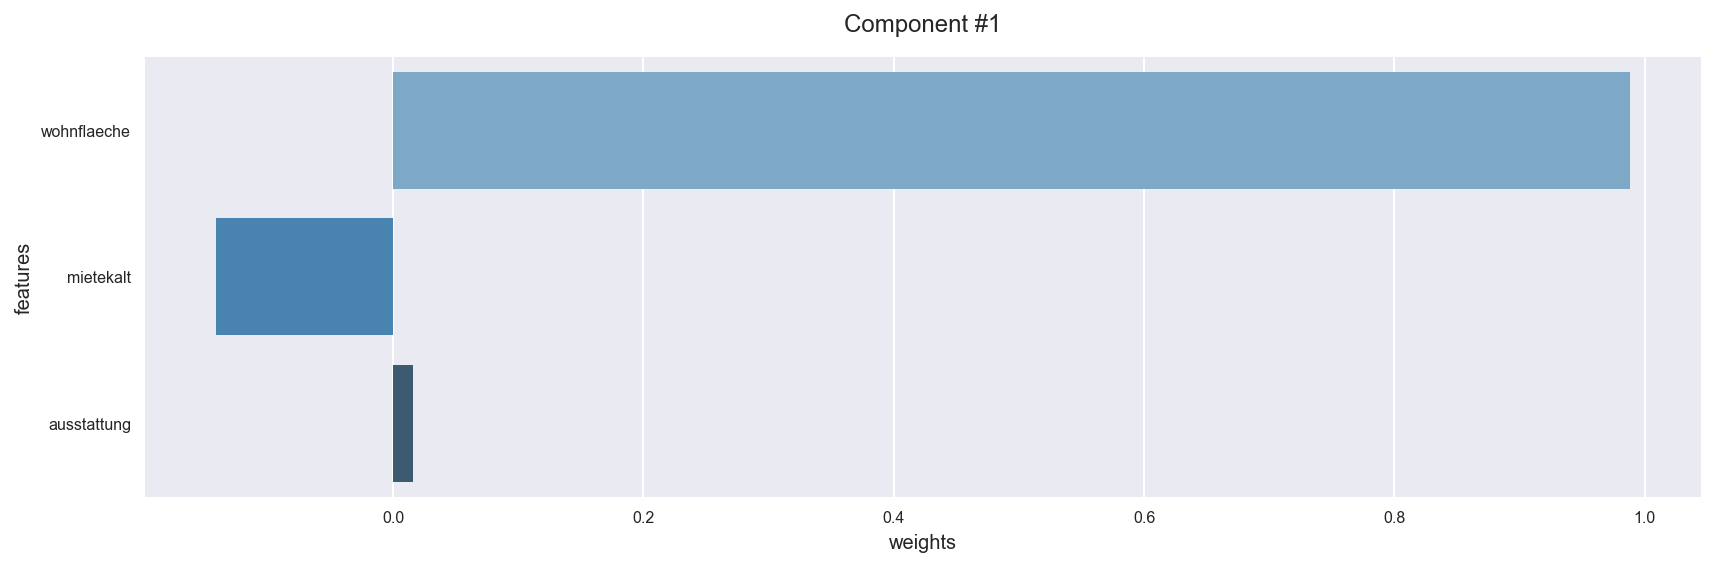

In [154]:
figure = plt.figure(figsize=(12,4.0))

for i in range(1):
    plt.subplot(1,1,i+1)
    f.display_components(v, clustering_df.columns, i, n_weights=3)
    plt.title('Component #{}'.format(i+1))
figure.tight_layout()




The component makeup shows that **wohnflache** and **mietekalt** are the main features. 

### Setup K-Means
Create K-Means analysis to find groups in customers based only on customer features

#### Create input data based on PCA analysis
Use the `pca.transform()` function to create input data for the K-Means analysis.

In [156]:
%%time
# Create input data from PCA Analysis
pca_transformed = pca.fit_transform(normalized_values)

pca_transformed = pd.DataFrame(pca_transformed)
pca_transformed = pca_transformed.iloc[:,:1]
PCA_list=['c_1']
pca_transformed.columns=PCA_list

pca_transformed.head()



CPU times: user 1min 23s, sys: 43.1 s, total: 2min 6s
Wall time: 40.6 s


,c_1
0,0.031864
1,0.024591
2,0.009932
3,0.009932
4,0.041829


#### Create an elbow graph tp determine the optimal number of clusters

In [157]:
%%time
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist


# Do a loop over different k's to find the optimum
inertias = []
distortions = []
for i in range(1,7):
    kmeans = KMeans(n_clusters=i).fit(pca_transformed)
    cluster_centers = kmeans.cluster_centers_
    inertias.append(kmeans.inertia_)
    
    distortions.append(sum(np.min(cdist(pca_transformed, kmeans.cluster_centers_,
                                        'euclidean'), axis=1)) / pca_transformed.shape[0])
                                        
    inertias.append(kmeans.inertia_)
    

CPU times: user 4min 4s, sys: 57.9 s, total: 5min 2s
Wall time: 48.2 s


In [158]:
distortions

[0.038414334863363105,
 0.020968182215668832,
 0.01482168935652802,
 0.011607928968821027,
 0.009612870928419084,
 0.00809104827158509]

#### Plot the elbow graph

<AxesSubplot:>

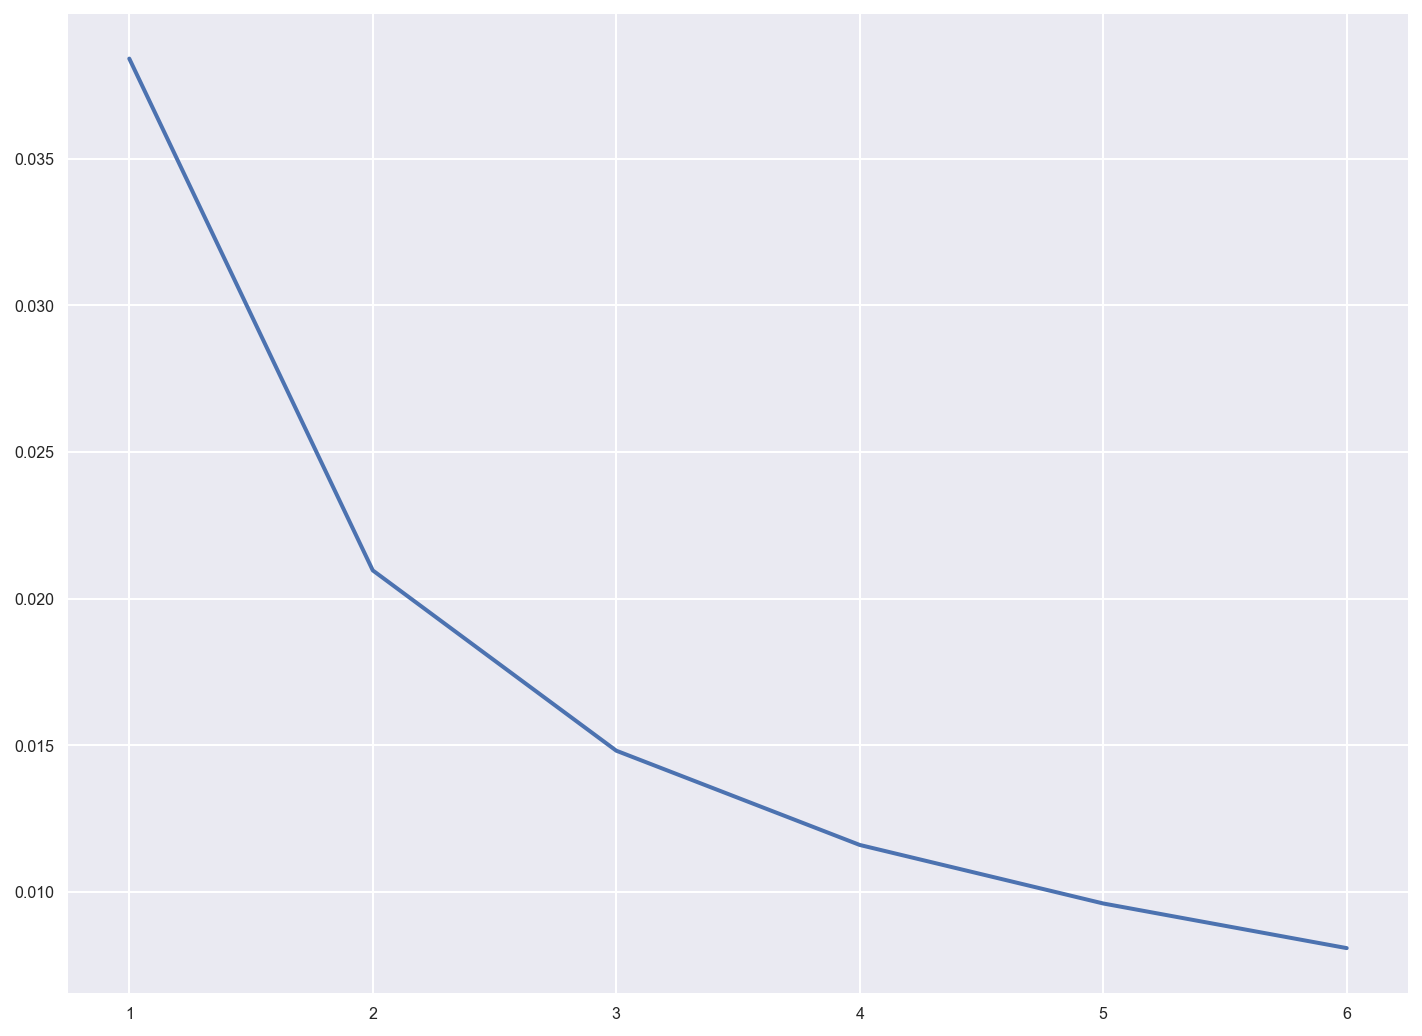

In [159]:
sns.lineplot(x=range(1,7), y=distortions)

#### Create the cluster with n_clusters=3

In [160]:
%%time
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3).fit(pca_transformed)
labels = kmeans.labels_

CPU times: user 33.6 s, sys: 7.99 s, total: 41.6 s
Wall time: 5.99 s


#### Visualize the effect on PCA to clusters

If you only have one PCA, I don't think this step makes that much sense, but I'll take it for the sake of completeness.

In [161]:
cluster_df = pd.DataFrame(kmeans.cluster_centers_, columns=pca_transformed.columns)


Text(0.5, 1.03, 'Attribute Value by Centroid')

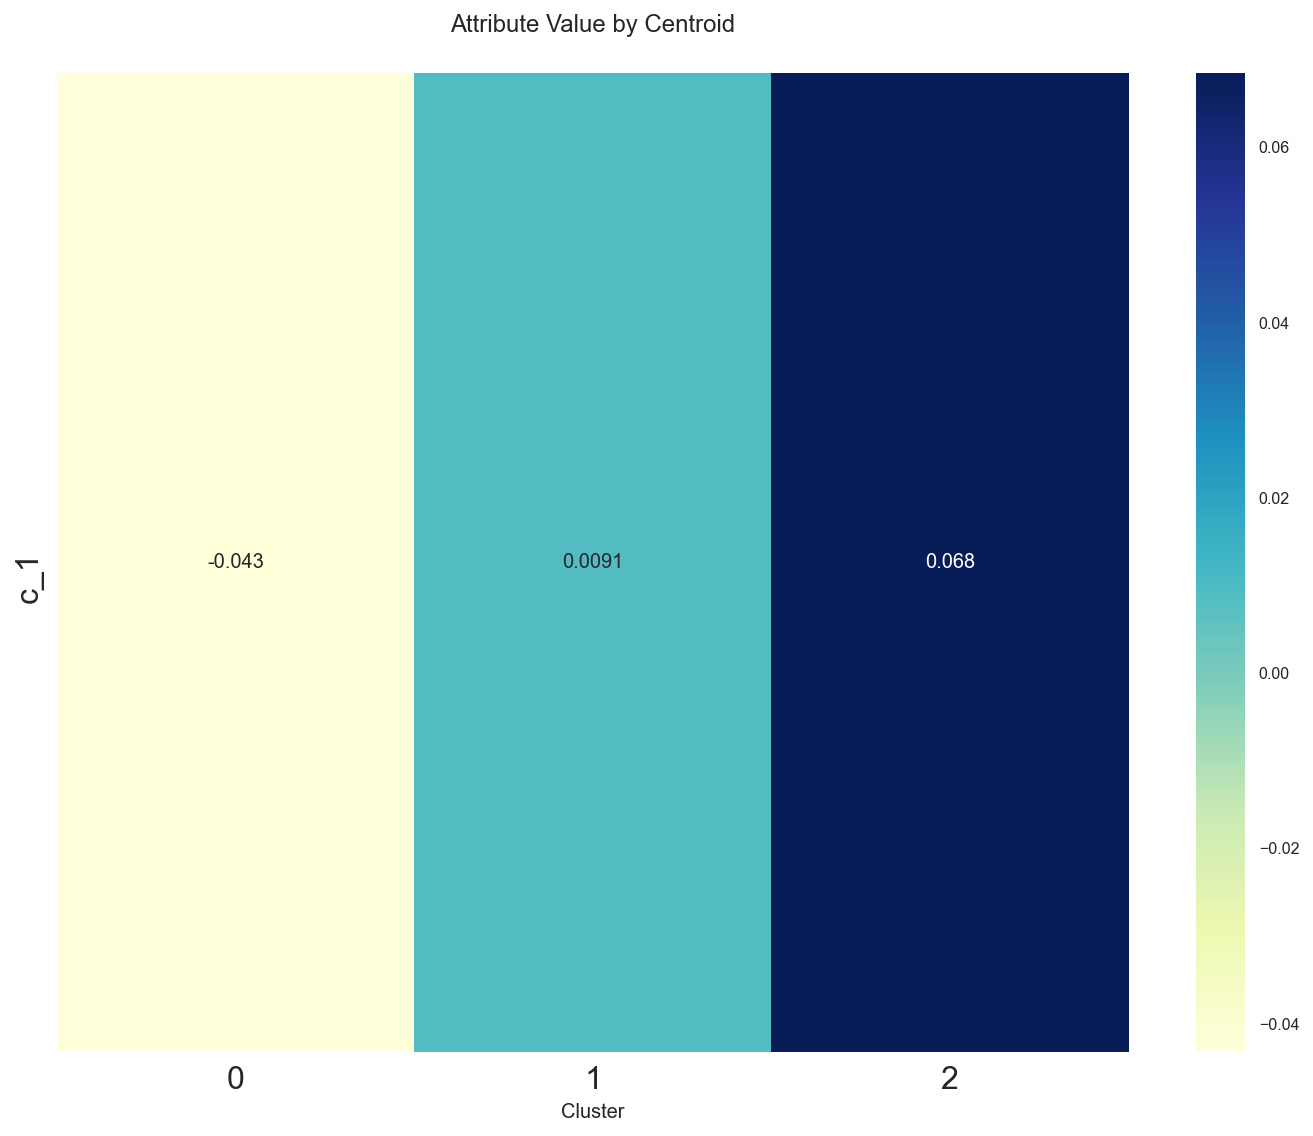

In [164]:
plt.figure(figsize = (12,9))
ax = sns.heatmap(cluster_df.T, cmap = 'YlGnBu', annot=True)
ax.set_xlabel("Cluster")
plt.yticks(fontsize = 16)
plt.xticks(fontsize = 16)
ax.set_title("Attribute Value by Centroid")



#### Add Clusters to dataframe


In [190]:
# Add the labels to dataframe
df.loc[:, 'label'] = labels

### Evaluate the clusters

#### How many datapoints are in each clusters?

Text(0, 0.5, 'Count')

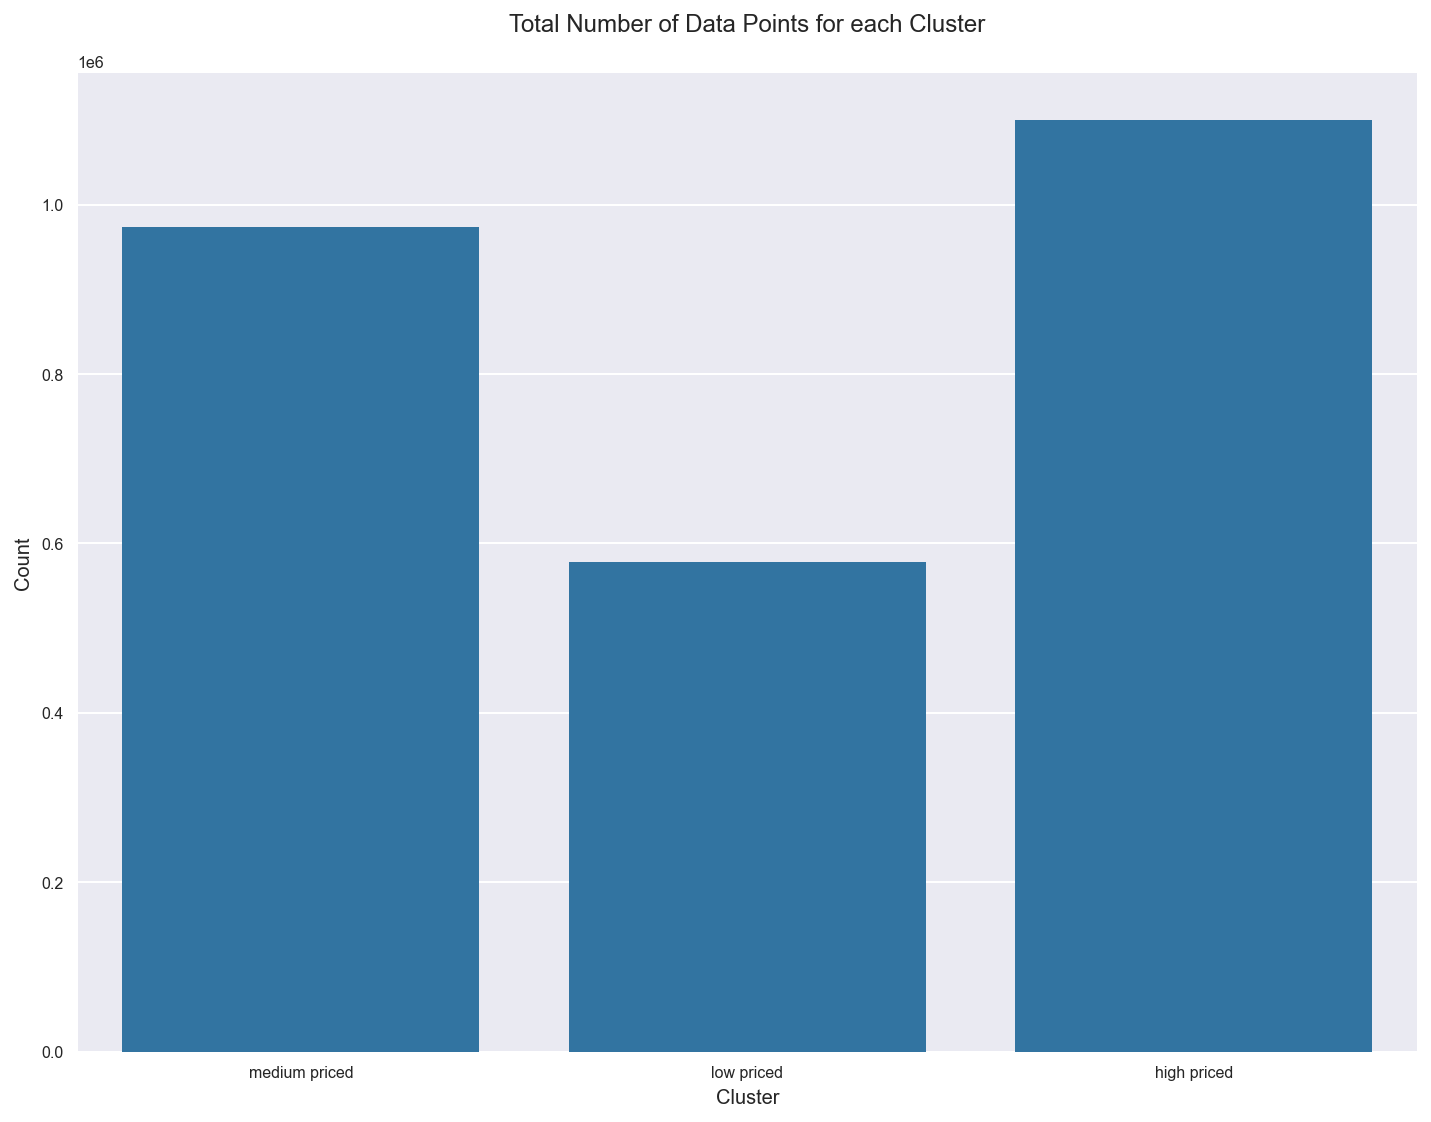

In [36]:
sns.countplot(data=df, x='label', color=blue)

plt.title('Total Number of Data Points for each Cluster')
plt.xlabel('Cluster')
plt.ylabel('Count')

#### How ist the mean “rent_sqm“ for each cluster?

Text(0.5, 1.03, 'Mean Rent for defined clusters')

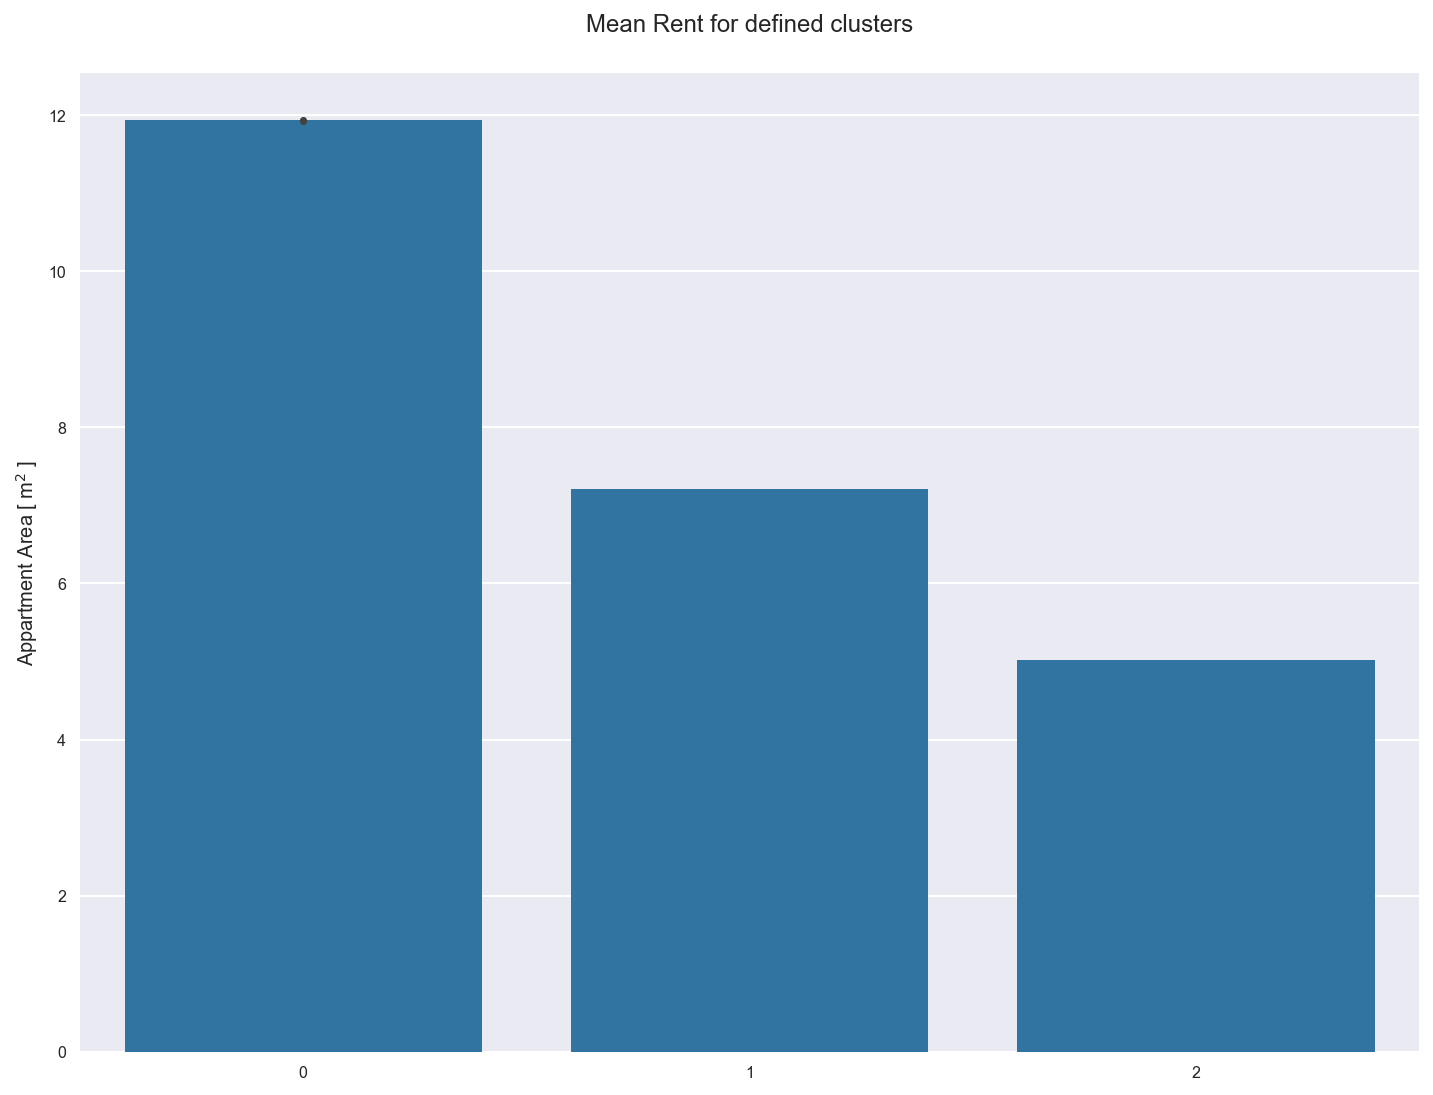

In [170]:
sns.barplot(data=df, x='label', y='rent_sqm', color=blue);
plt.xlabel(None)
plt.ylabel('Appartment Area [ m$^2$ ]')
plt.title('Mean Rent for defined clusters')



Here we see a clear seperation for the cluster. From **0 - high priced**  to **2 - low priced**. Let's check how many overlapping are in the distributions of rent per sqm in different clusters.

Text(0, 0.5, 'Frequency')

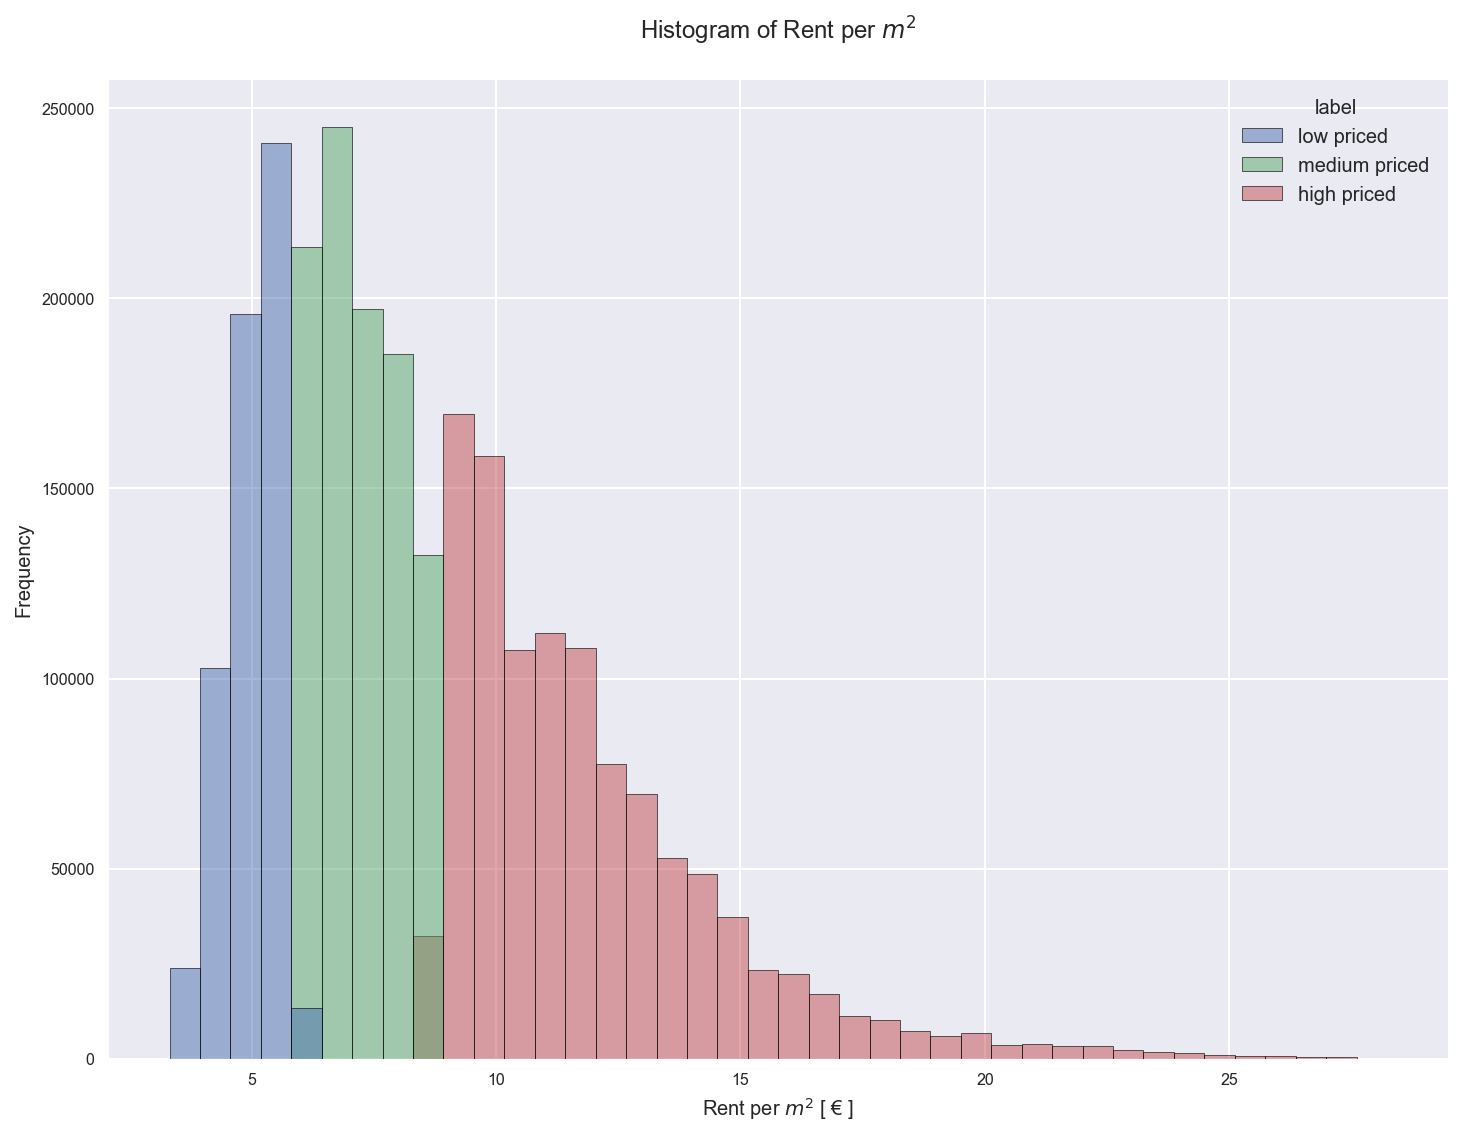

In [58]:
sns.histplot(data=df, x='rent_sqm', hue='label', bins=40, hue_order=label_order)
plt.title('Histogram of Rent per $m^2$')
plt.xlabel('Rent per $m^2$ [ € ]')
plt.ylabel('Frequency')

The overlapping is very less.

#### How ist the mean “wohnflaeche“ for each cluster?

Text(0.5, 1.03, 'Mean Rent for defined clusters')

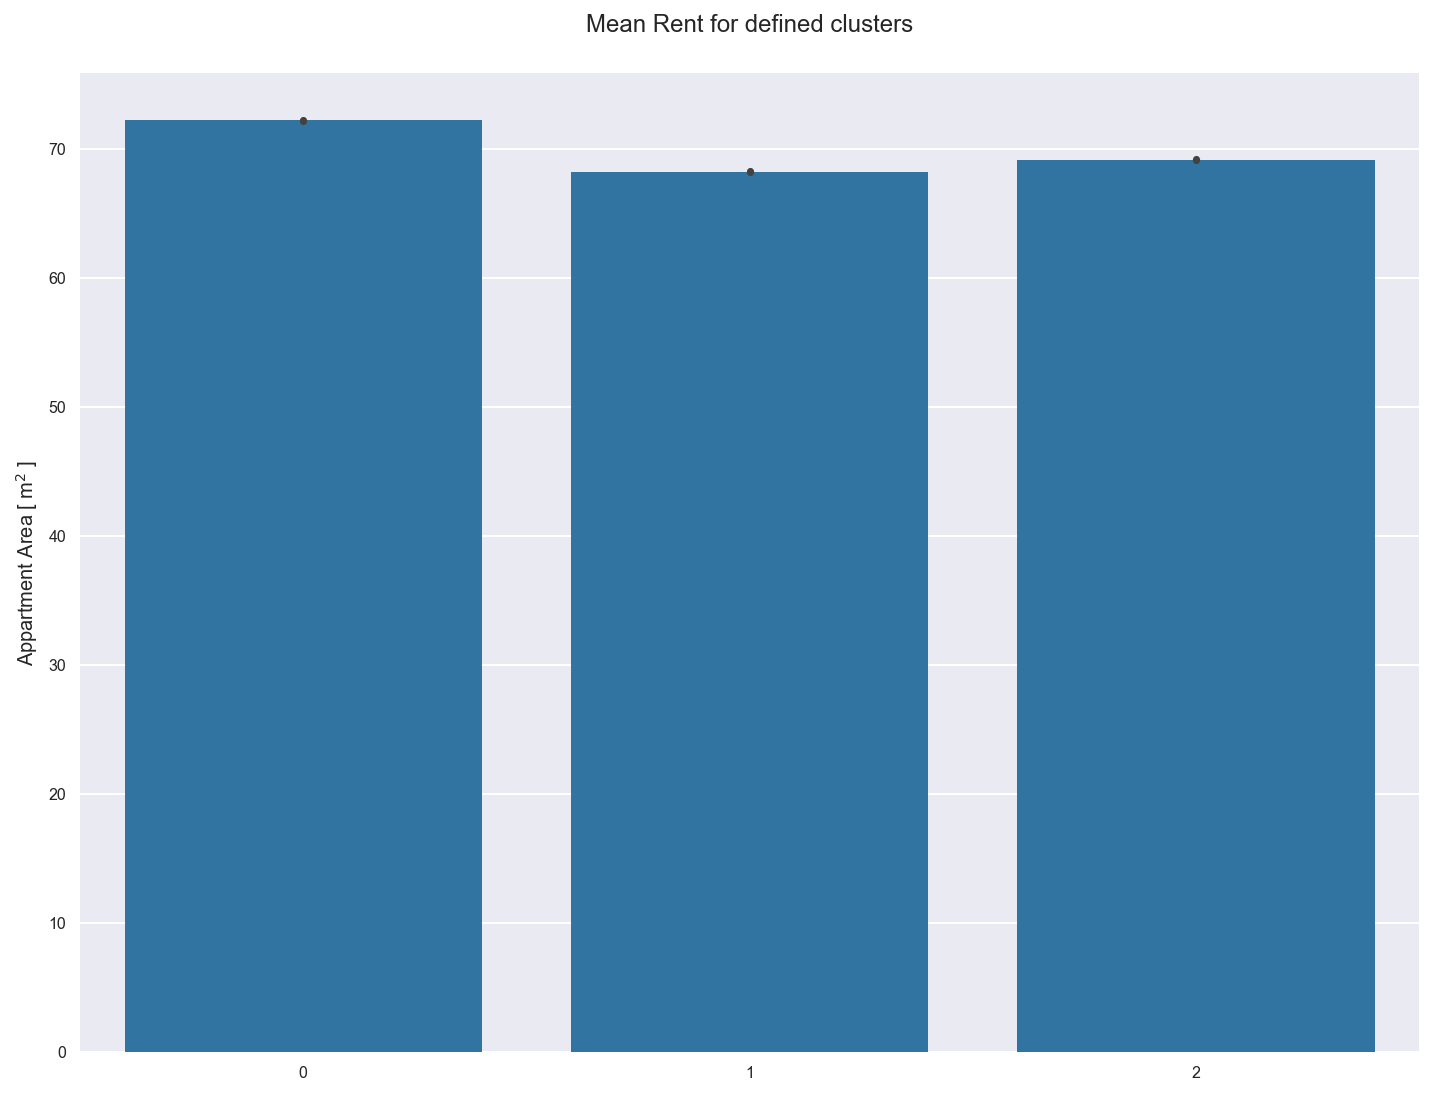

In [169]:
sns.barplot(data=df, x='label', y='wohnflaeche', color=blue);
plt.xlabel(None)
plt.ylabel('Appartment Area [ m$^2$ ]')
plt.title('Mean Rent for defined clusters')



Regarding the **wohnflaeche** there is no difference in the clusters. Therefore it seems that it has an influence to the PCA but not to the cluster

Text(0, 0.5, 'Frequency')

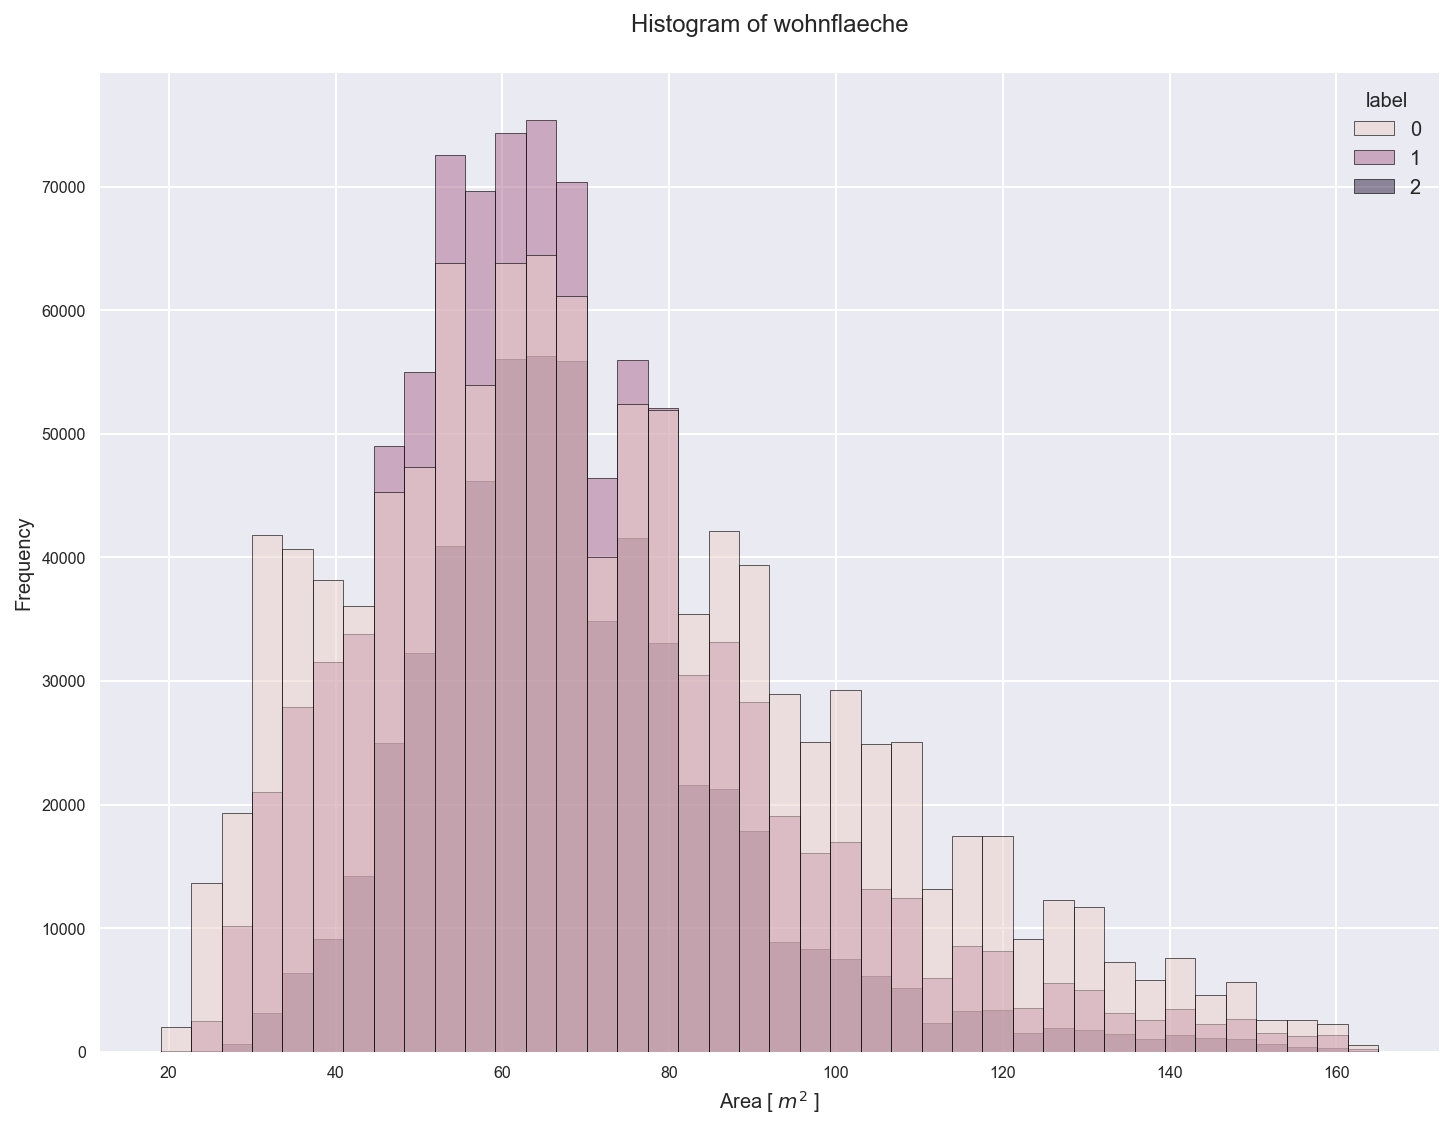

In [177]:
sns.histplot(data=df, x='wohnflaeche', hue='label', bins=40)
plt.title('Histogram of wohnflaeche')
plt.xlabel('Area [ $m^2$ ]')
plt.ylabel('Frequency')

In contrast to the distribution of the prices per m2, we cannot distinguish any separation of the clusters in the living space.

#### How is the count for the different “aussttattung“ values per cluster

In [172]:
df.ausstattung.fillna('Unbekannt', inplace=True)

In [173]:
ausstattung = df.groupby(['label']).ausstattung.value_counts(dropna=False, normalize=True).reset_index(name='ausstattung_count')
ausstattung.head()

,label,ausstattung,ausstattung_count
0,0,Unbekannt,0.451476
1,0,Gehoben,0.325182
2,0,Normal,0.179447
3,0,Luxus,0.039116
4,0,Einfach,0.004778


Text(0, 0.5, 'Ausstattung Count Ratio')

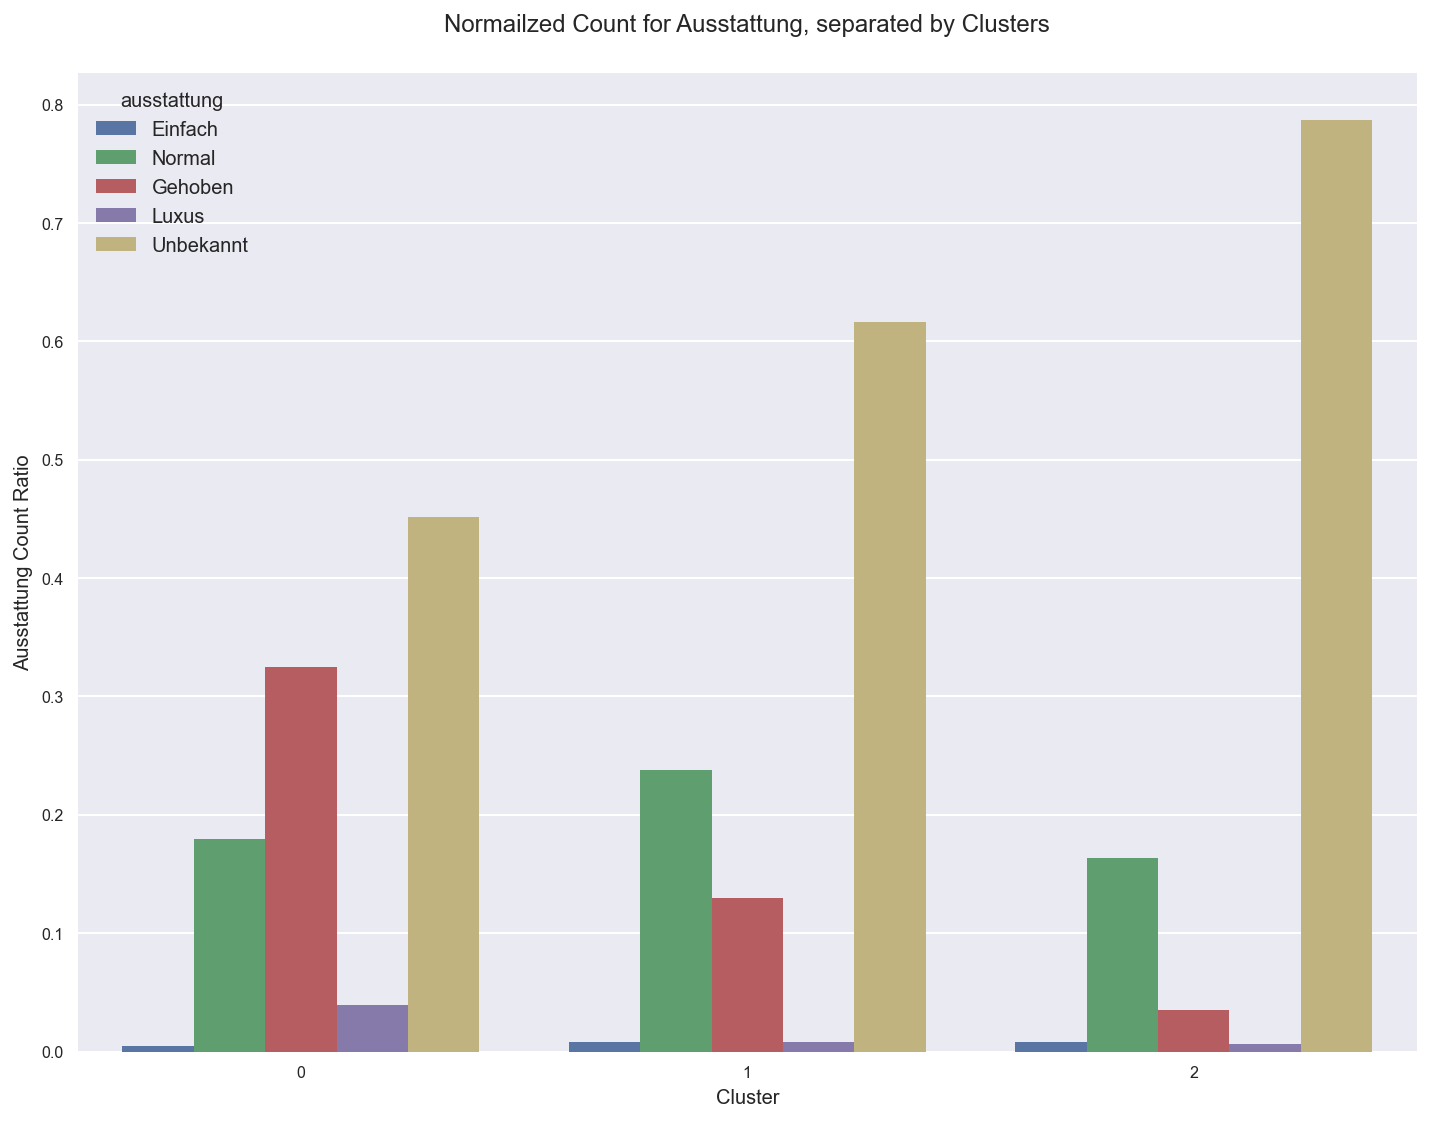

In [175]:
ausstattung_order = ['Einfach', 'Normal', 'Gehoben', 'Luxus', 'Unbekannt']


sns.barplot(data=ausstattung, x='label', y='ausstattung_count', hue='ausstattung', hue_order=ausstattung_order)
plt.title('Normailzed Count for Ausstattung, separated by Clusters')
plt.xlabel('Cluster')
plt.ylabel('Ausstattung Count Ratio')

In general the most values are **unbekannt**. In the **high priced cluster 0** are more **“Gehoben“ than “Normal“** in clusters 1 and 2 it's vice versa. Its make sense, that hig priced clusters have more better quality appartments.

### Cluster Definition
Due to previous cluster investigations I decide to rename my clusters in **low priced**, **medium priced** and **high priced**.

In [192]:
df.label.value_counts()

0    1105814
1     972460
2     573611
Name: label, dtype: int64

In [193]:
# map the labels
# Attention label_mapping needs update
label_mapping = {0:'high priced', 1:'medium priced', 2:'low priced'}


df.label = df.label.map(label_mapping)



In [194]:
# Define some orders for plot order
label_order = ['low priced', 'medium priced', 'high priced']

 

#### Check with new cluster names

Text(0.5, 1.03, 'Mean Rent for defined clusters')

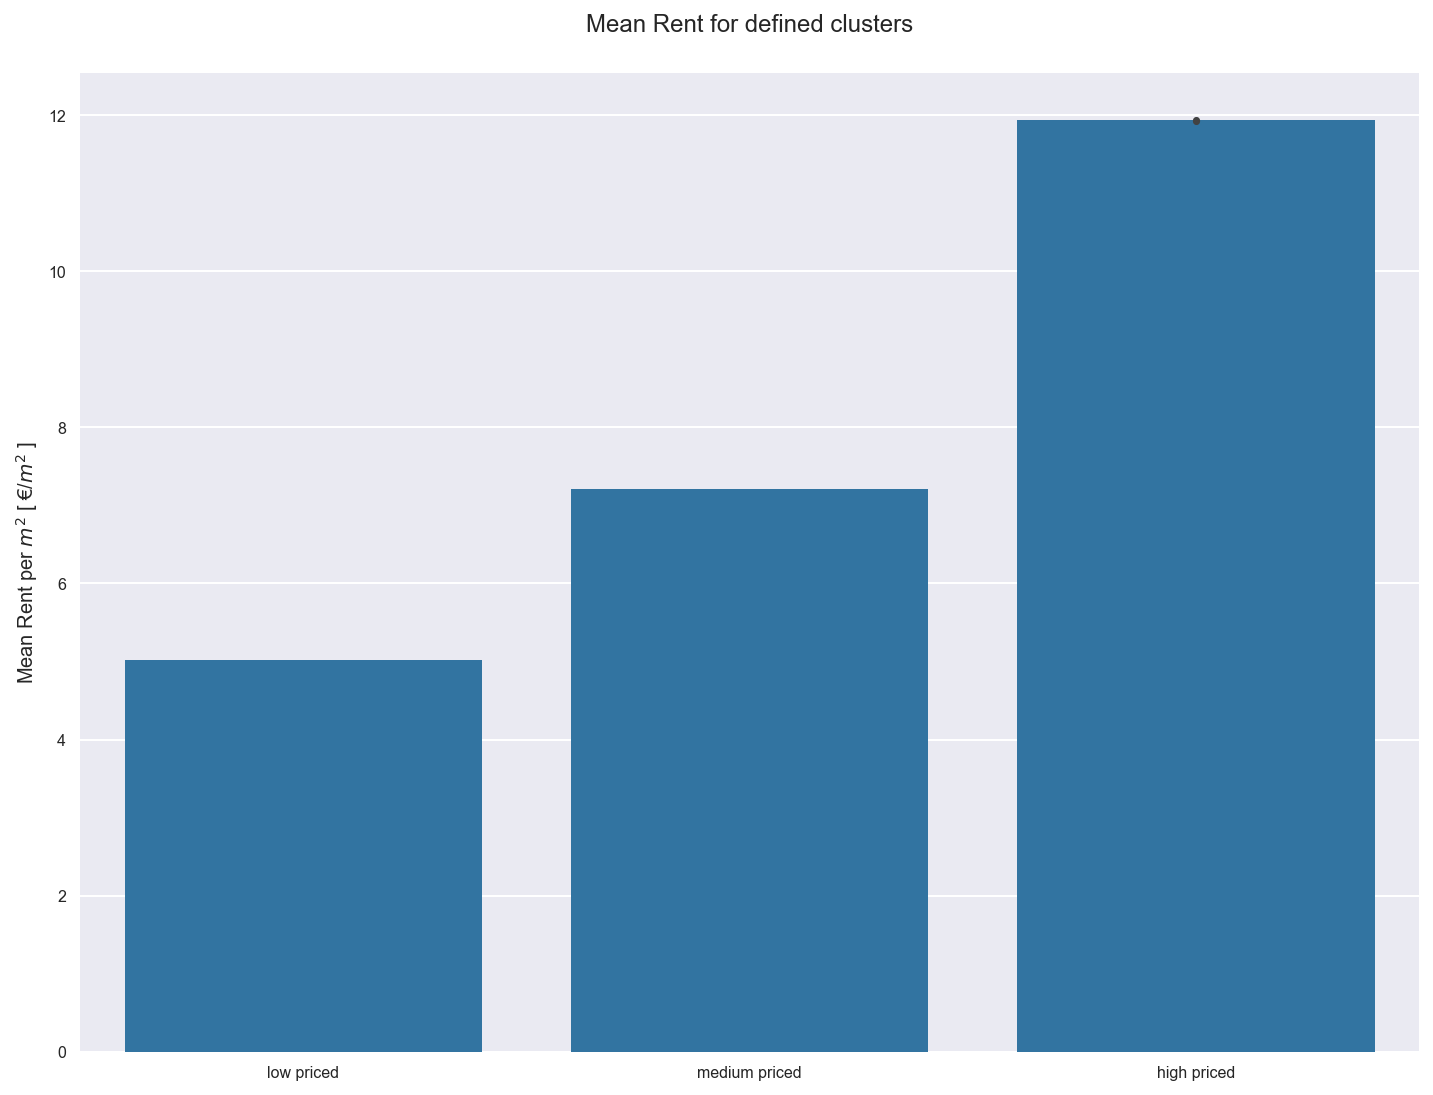

In [195]:
# Create Plot with mean rents for cluster
# , order=label_order, color=blue
sns.barplot(data=df, x='label', y='rent_sqm', order=label_order, color=blue);
plt.xlabel(None)
plt.ylabel('Mean Rent per $m^2$ [ €/$m^2$ ]')

plt.title('Mean Rent for defined clusters')

### Pickle the dataframe

In [196]:
df.to_pickle('data/rent_clustered.pkl')

# Section 4 Evaluation

In [197]:
df = pd.read_pickle('data/rent_clustered.pkl')

## Part 1: How to Break into the Field

### How is the rent increasing over time

In [198]:
mean_rent_sqm = df.groupby('year').rent_sqm.mean().reset_index(name='rent_sqm_mean')



Text(0, 0.5, 'Rent per $m^2$ [ € ]')

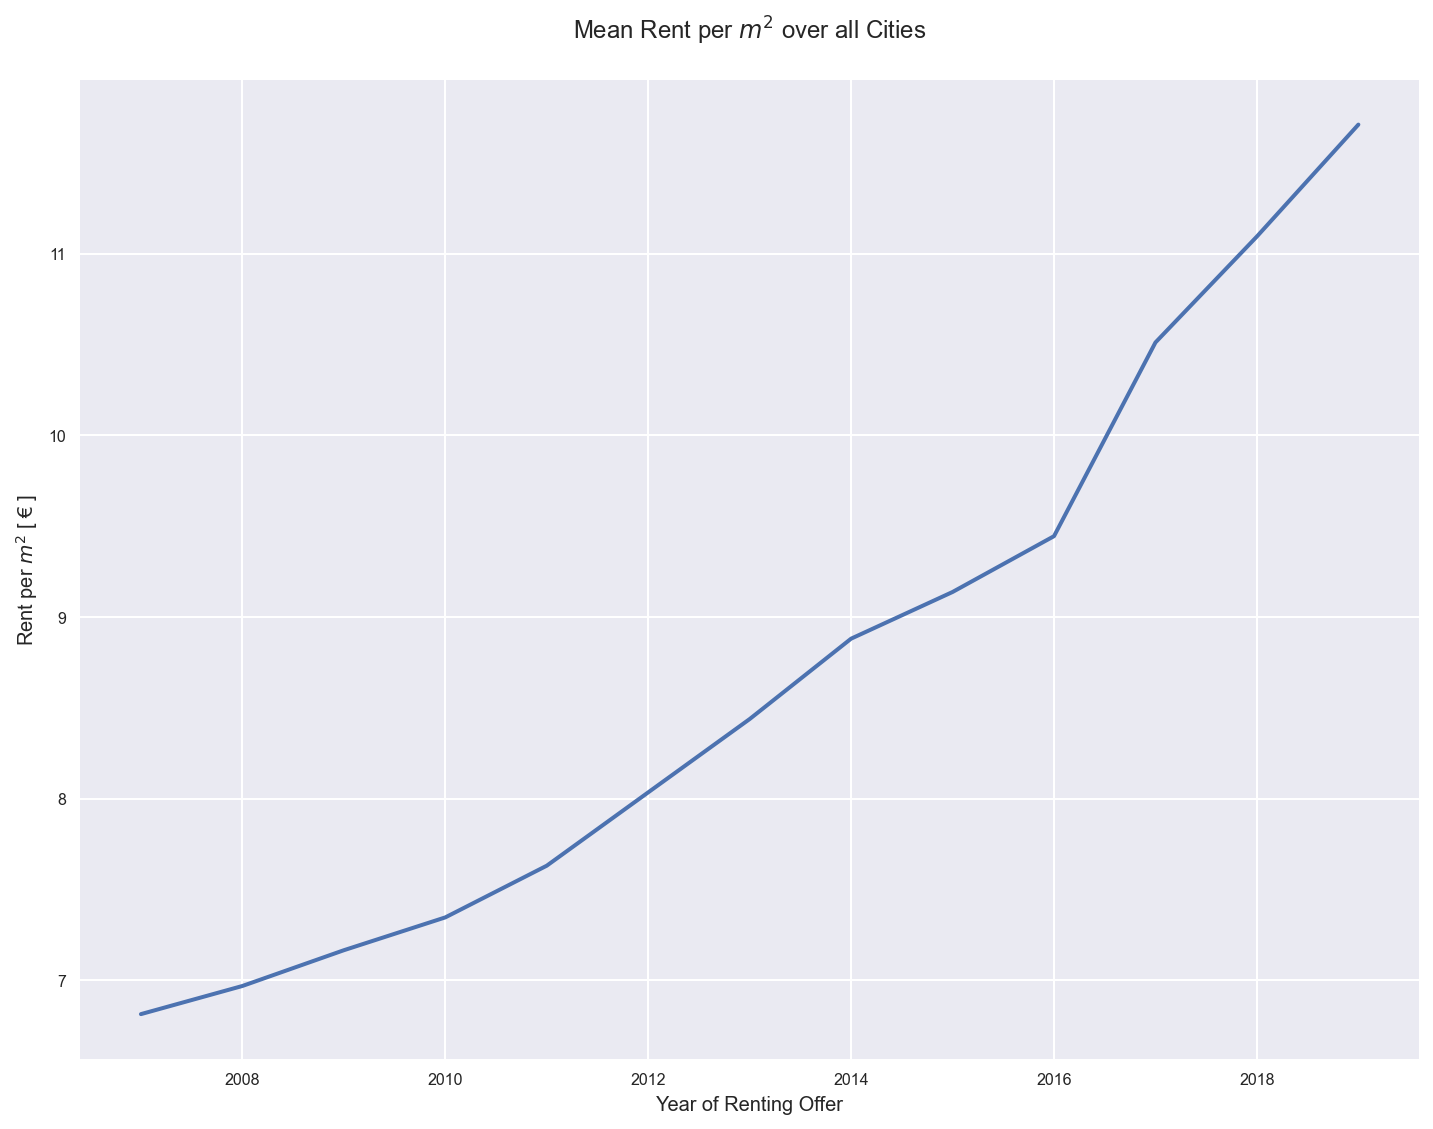

In [199]:

sns.lineplot(data=mean_rent_sqm, x='year', y='rent_sqm_mean', legend=True)
plt.title('Mean Rent per $m^2$ over all Cities')
plt.xlabel('Year of Renting Offer')
plt.ylabel('Rent per $m^2$ [ € ]')

In [200]:
# Calculate percentage change  from 2008 to 2019
mean_rent_sqm.iloc[12, 1] / mean_rent_sqm.iloc[0, 1] * 100 - 100

71.87191354070143

If you summarize the rent per m2 across all offers and look at the development over the years, you have to say that living has become extremely expensive.
Relative to 2007 the prices increases by72%.

## Part 2: How the cluster change over time


#### Change of cluster rent sqm mean over time

In [201]:
# Create Aggregation year and label rent_sqm mean 
rent_sqm_mean = df.groupby(['year', 'label']).rent_sqm.mean().reset_index(name='rent_sqm_mean')
rent_sqm_mean.head()

,year,label,rent_sqm_mean
0,2007,high priced,10.286186
1,2007,low priced,4.907580
2,2007,medium priced,7.095218
3,2008,high priced,10.459280
4,2008,low priced,4.948929


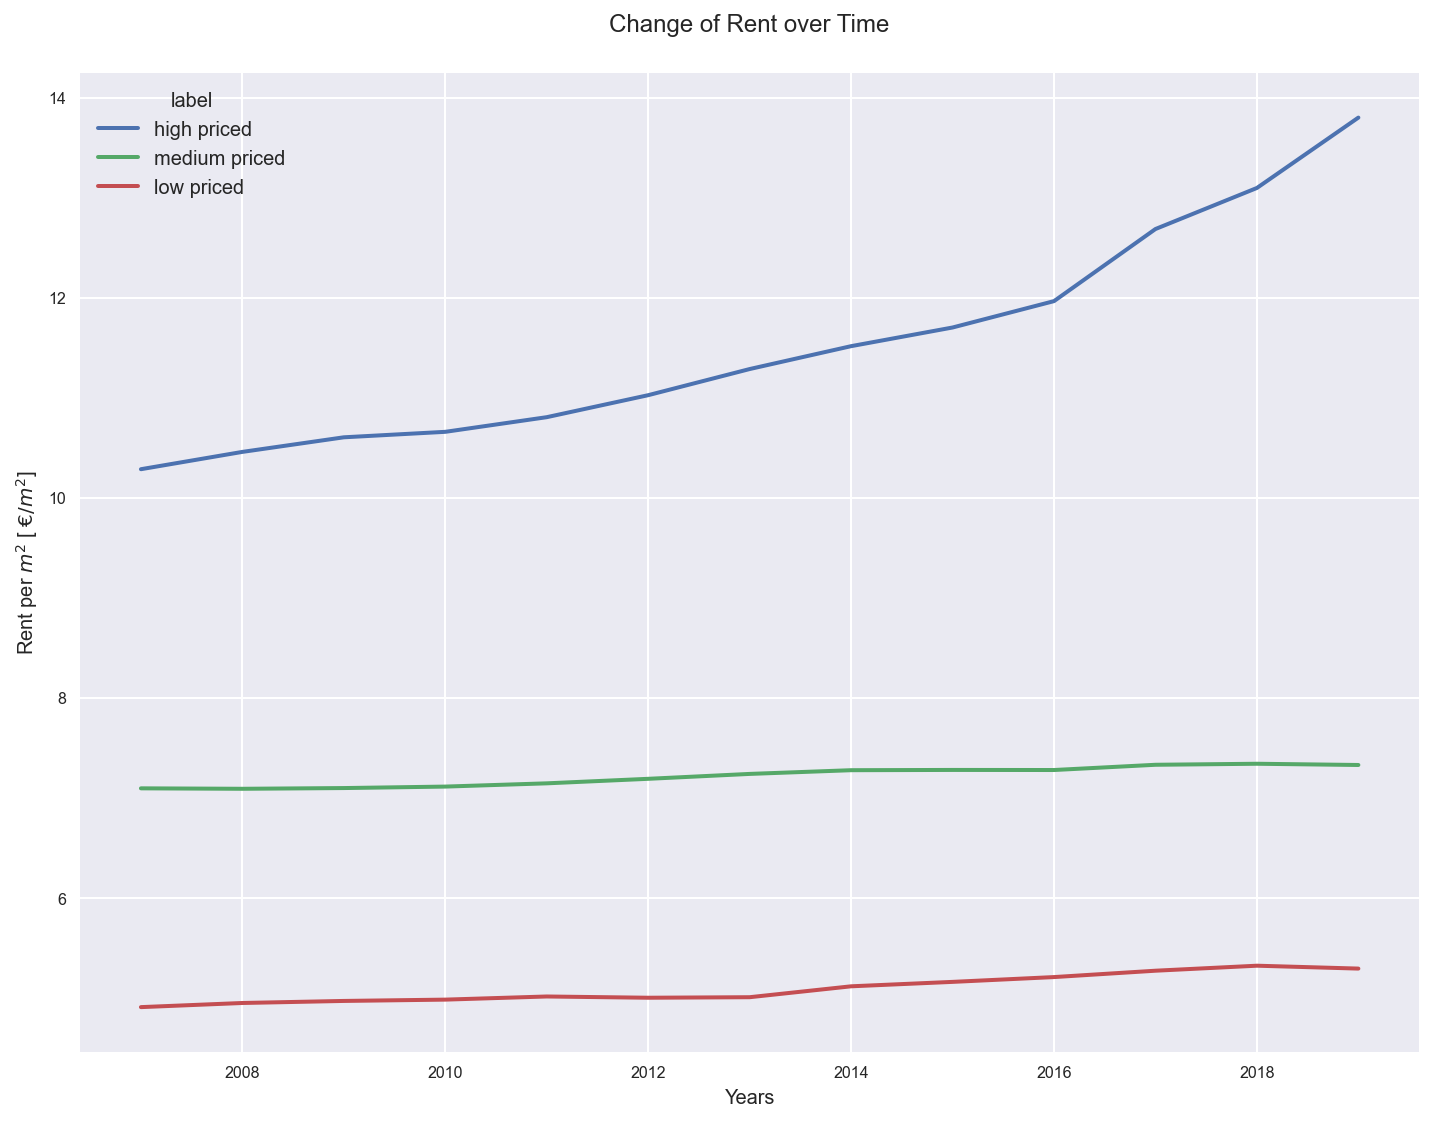

In [202]:
sns.lineplot(data=rent_sqm_mean, x='year', y='rent_sqm_mean', hue='label', hue_order=label_order[::-1])
plt.title('Change of Rent over Time')
plt.xlabel('Years')
plt.ylabel('Rent per $m^2$ [ $€/m^2$]');

Only the already high-priced cluster will be more expensive. The other two change only minimally in terms of price.

#### How changed the cluster size over the time

**Aggregted over years**

In [203]:
label_count_time = df.groupby(['year']).label.value_counts(normalize=True).reset_index(name='label_count')
label_count_time.head()

,year,label,label_count
0,2007,low priced,0.420145
1,2007,medium priced,0.379889
2,2007,high priced,0.199967
3,2008,low priced,0.396750
4,2008,medium priced,0.387092


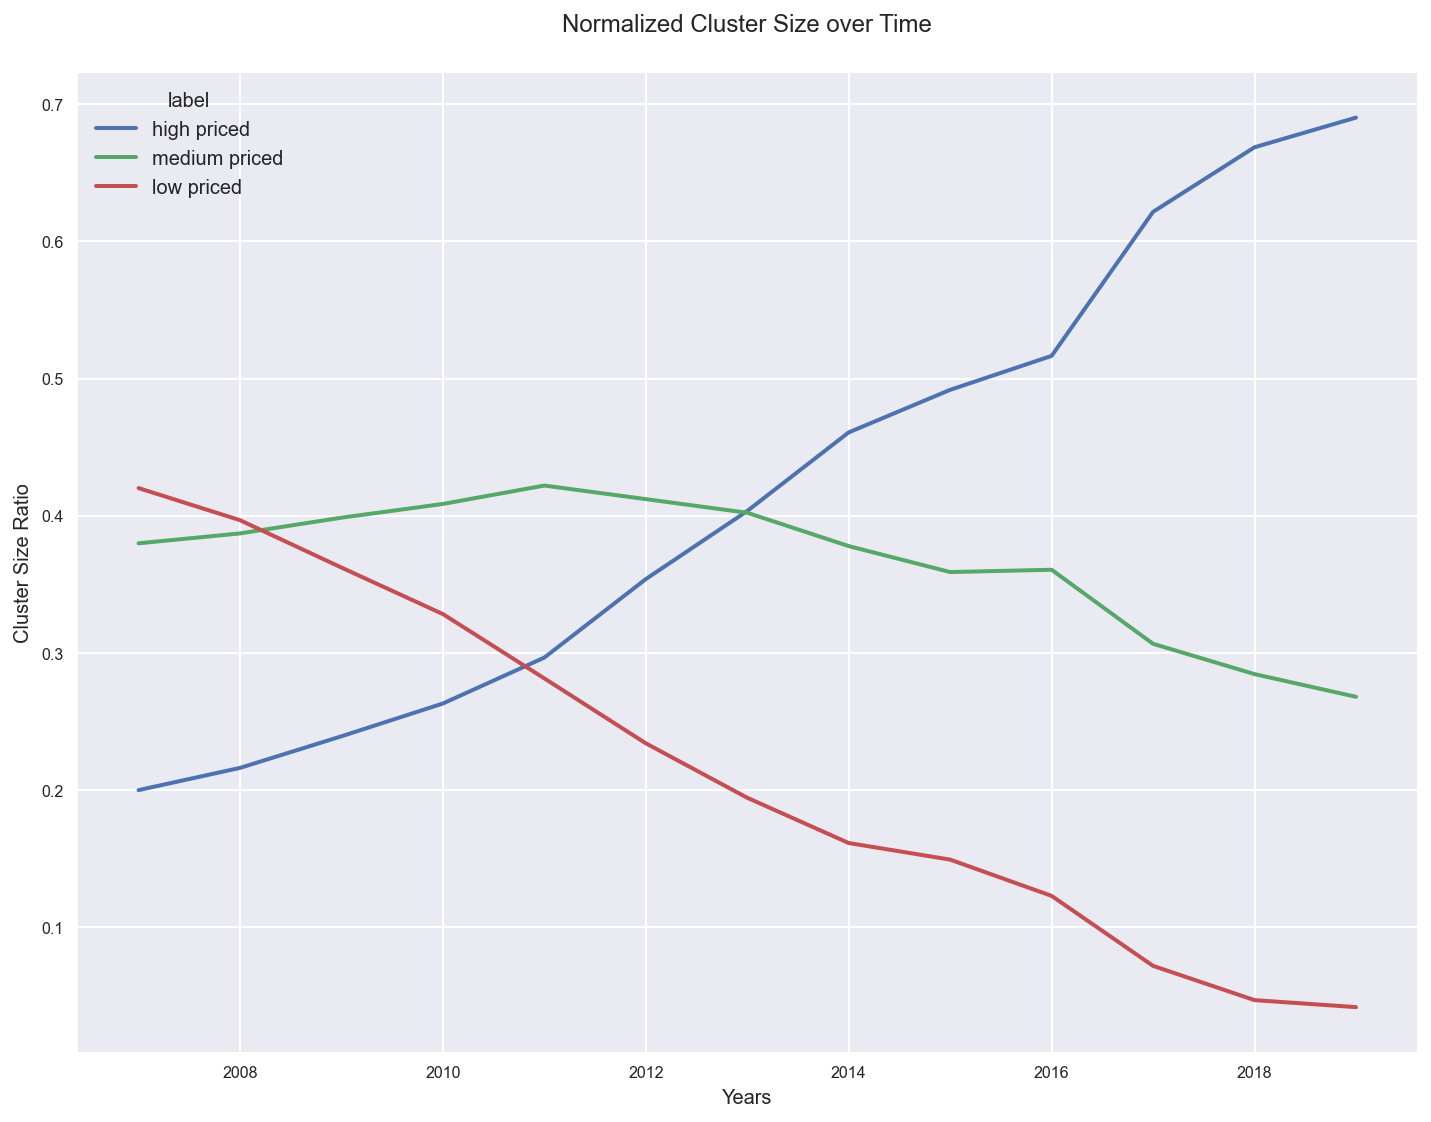

In [204]:
sns.lineplot(data=label_count_time, x='year', y='label_count', hue='label', hue_order=label_order[::-1])
plt.title('Normalized Cluster Size over Time')
plt.xlabel('Years')
plt.ylabel('Cluster Size Ratio');

the low-priced and medium-priced clusters become smaller over time, while the high-priced cluster becomes larger.

**Aggregated over city and years**

In [206]:
label_count_city_year = df.groupby(['City','year']).label.value_counts(normalize=True).reset_index(name='label_count')
label_count_city_year.head()

,City,year,label,label_count
0,Berlin,2007,low priced,0.626101
1,Berlin,2007,medium priced,0.340656
2,Berlin,2007,high priced,0.033243
3,Berlin,2008,low priced,0.579857
4,Berlin,2008,medium priced,0.377511


**Display Cluster Change over years for each city**

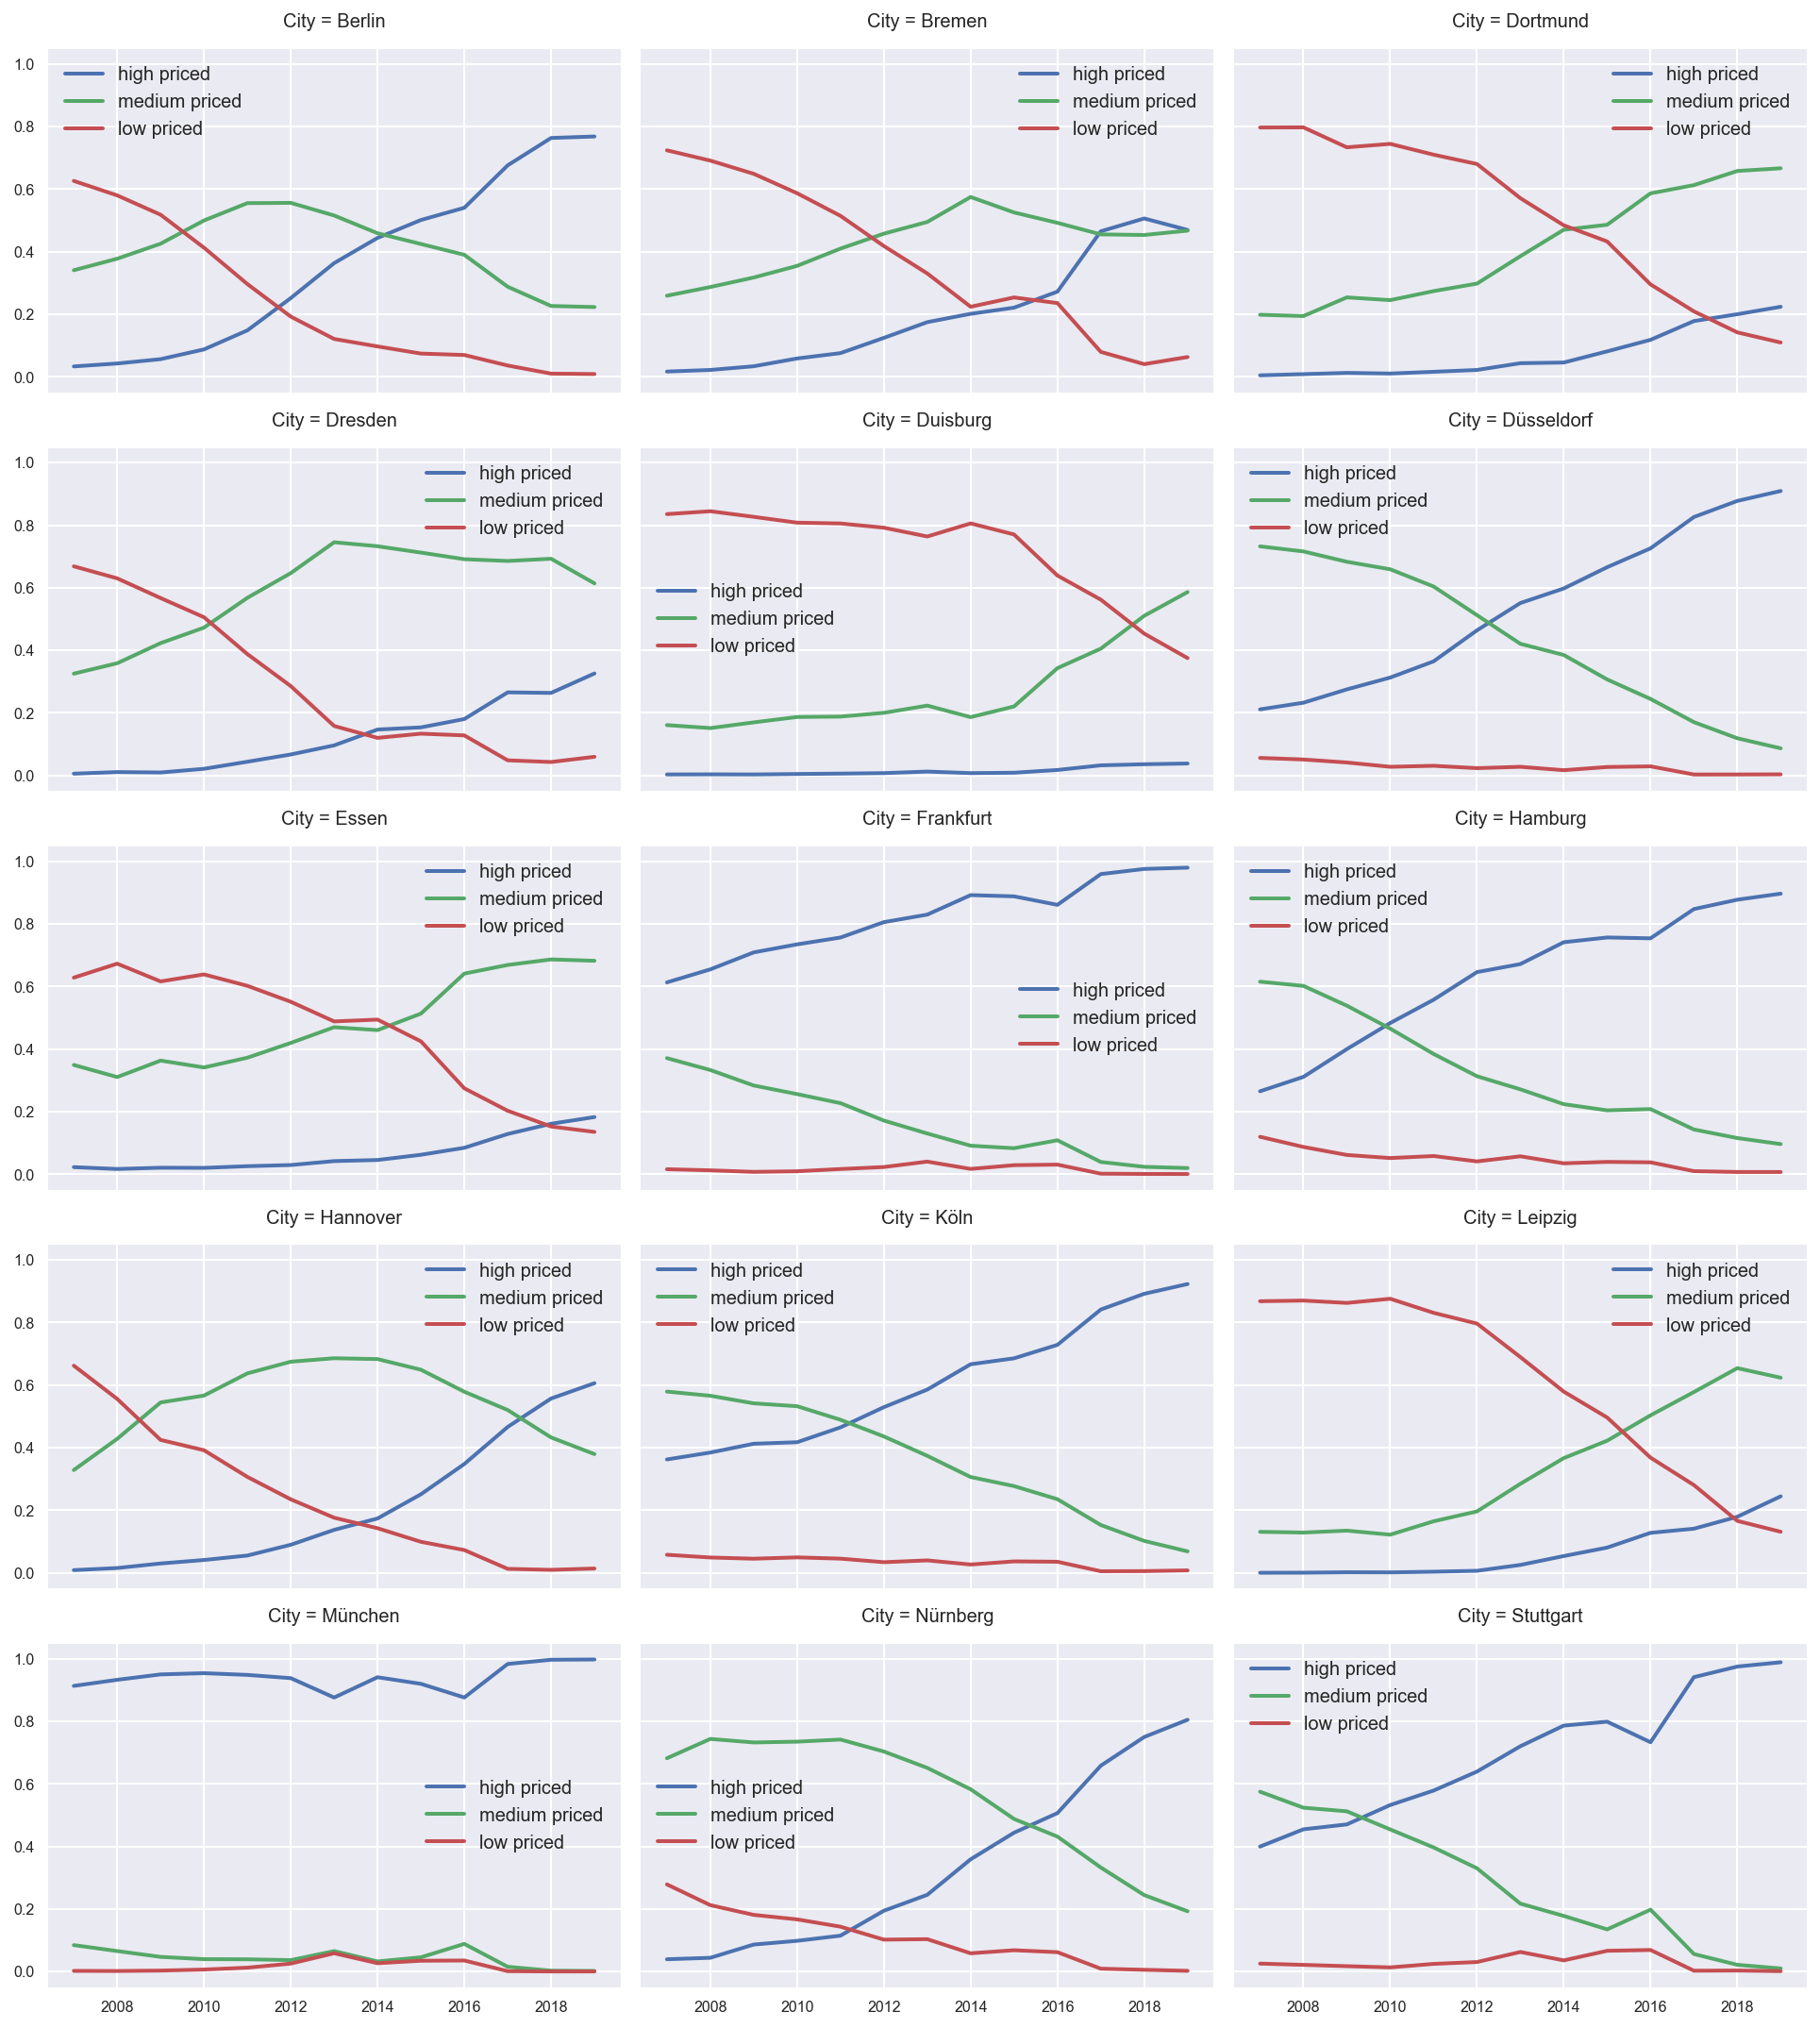

In [211]:
g = sns.FacetGrid(data=label_count_city_year, col='City', col_wrap=3, height=3, aspect=1.5)
g.map_dataframe(sns.lineplot, x='year', y='label_count', hue='label', hue_order=label_order[::-1])

for ax in g.axes.ravel():
    ax.legend()



**German**<br>
Die Städte verhalten sich über die Zeit sehr unterschiedlich. München hat im betrachteten Zeitraum nie nennenswert güstigen Wohnungen im Sinne des Clustering gehabt. Im Gegensatz dazu war Leipzig die Hauptstadt der günstigen Wohnungen und hat über die Jahre massiv an günstigen Wohnraum verloren. 

**English**<br>
The cities behave very differently over time. In the period under review, Munich never had **low priced*+ or **normal priced** apartments worth mentioning in terms of clustering. In contrast, Leipzig was the capital of **low priced appartment** apartments and has lost a lot of **low priced** living space over the years.

**German**<br>
Wie wäre es wenn wir die Cluster Werte für das Jahr 2007 nehmen und mit einer angenommenen Inflation von 2% pro Jahr verteuern. Dann könnten wir ggf. die Wohnungen neu einsortieren. WEs gibt ja eine Inflation, in diesem Sinne dürfen Wohnungen über die Zeit teurer werden. Kann ich also eine Wohnung von medium priced cluster auf low priced cluster zurückstufen, weil sie unter einer 2% Inflation vom Preis zum low priced cluster gehören würde.
Berechnen die Mittleren Mieten aggregiert über Die Stadt und den Cluster für das Jahr 2007. Davon ausgenehnd berechnen wir die Mieten für 2008 - 2019 mit einer jährlichen Teuerung von 2%.

**English**<br>
How about if we take the cluster values for 2007 and assume an inflation rate of 2% per year. Then we could re-sort the apartments if necessary. There is inflation, in this sense, apartments can become more expensive over time. So can I downgrade an apartment from a medium-priced cluster to a low-priced cluster because it would belong to the low-priced cluster under a 2% inflation of the price?
Calculate the mean rents aggregated over the city and the cluster for the year 2007. Based on this, we calculate the rents for 2008 - 2019 with an annual inflation rate of 2%. 

#### Change in the mean cluster price over the years based on 2007 assuming 2% inflation

In [320]:
rent_sqm_inflation = df.query('year==2007').groupby(['City', 'label']).rent_sqm.mean().reset_index(name=2007)
rent_sqm_inflation.head(2)

,City,label,2007
0,Berlin,high priced,9.878609
1,Berlin,low priced,4.895362


In [321]:
## Base series to start
series = rent_sqm_inflation[2007]
## loop over the years
for i in range(2007,2019,1):
    ## calculate new series based on current series with 2% increase 
    series = pd.Series(series*1.02, name=i+1)
    ## Join new series to dataframe
    rent_sqm_inflation = rent_sqm_inflation.join(series)



In [322]:
rent_sqm_inflation.head(3)

,City,label,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,Berlin,high priced,9.878609,10.076181,10.277705,10.483259,10.692924,10.906783,11.124918,11.347417,11.574365,11.805852,12.041970,12.282809,12.528465
1,Berlin,low priced,4.895362,4.993269,5.093135,5.194997,5.298897,5.404875,5.512973,5.623232,5.735697,5.850411,5.967419,6.086767,6.208503
2,Berlin,medium priced,6.770782,6.906197,7.044321,7.185208,7.328912,7.475490,7.625000,7.777500,7.933050,8.091711,8.253545,8.418616,8.586988


In [323]:
# Melt the Dataframe for easy visualization
rent_sqm_inflation_melt = rent_sqm_inflation.melt(id_vars=['City', 'label']).rename(columns={'variable': 'year', 'value': 'rent_sqm_2%'})
rent_sqm_inflation_melt

,City,label,year,rent_sqm_2%
0,Berlin,high priced,2007,9.878609
1,Berlin,low priced,2007,4.895362
2,Berlin,medium priced,2007,6.770782
3,Bremen,high priced,2007,9.645231
4,Bremen,low priced,2007,4.783798
...,...,...,...,...
580,Nürnberg,low priced,2019,6.652824
581,Nürnberg,medium priced,2019,8.641112
582,Stuttgart,high priced,2019,12.646181
583,Stuttgart,low priced,2019,6.724782


**German**<br>
Wir haben jetzt ausgehend von der mittleren Miete pro sqm pro Stadt und label von 2007 an die mittleren Mieten für die folgenden Jahre berechnet unter Annahme einer 2% Inflation. Diese Werte ergänzen zu einem Dataframe mit den mittleren Mieten aggregiert pro Stadt, Jahr und Cluster.

**English**<br>
Based on the average rent per sqm per city and label from 2007 onwards, we have calculated the average rents for the following years, assuming 2% inflation. These values are added to a data frame with the average rents aggregated per city, year and cluster.

In [325]:
rent_sqm_mean_city_year_label = df.groupby(['City', 'label', 'year']).rent_sqm.mean().reset_index(name='rest_sqm_mean')
rent_sqm_mean_city_year_label = rent_sqm_mean_city_year_label.merge(rent_sqm_inflation_melt, left_on=['City', 'label', 'year'], right_on=['City', 'label', 'year']).melt(id_vars=['City', 'label', 'year'])
rent_sqm_mean_city_year_label.head()

,City,label,year,variable,value
0,Berlin,high priced,2007,rest_sqm_mean,9.878609
1,Berlin,high priced,2008,rest_sqm_mean,10.041270
2,Berlin,high priced,2009,rest_sqm_mean,10.092725
3,Berlin,high priced,2010,rest_sqm_mean,10.090975
4,Berlin,high priced,2011,rest_sqm_mean,10.187427


**Display the mean rent sqm per city and cluster together with an hypothetical 2% inflation**

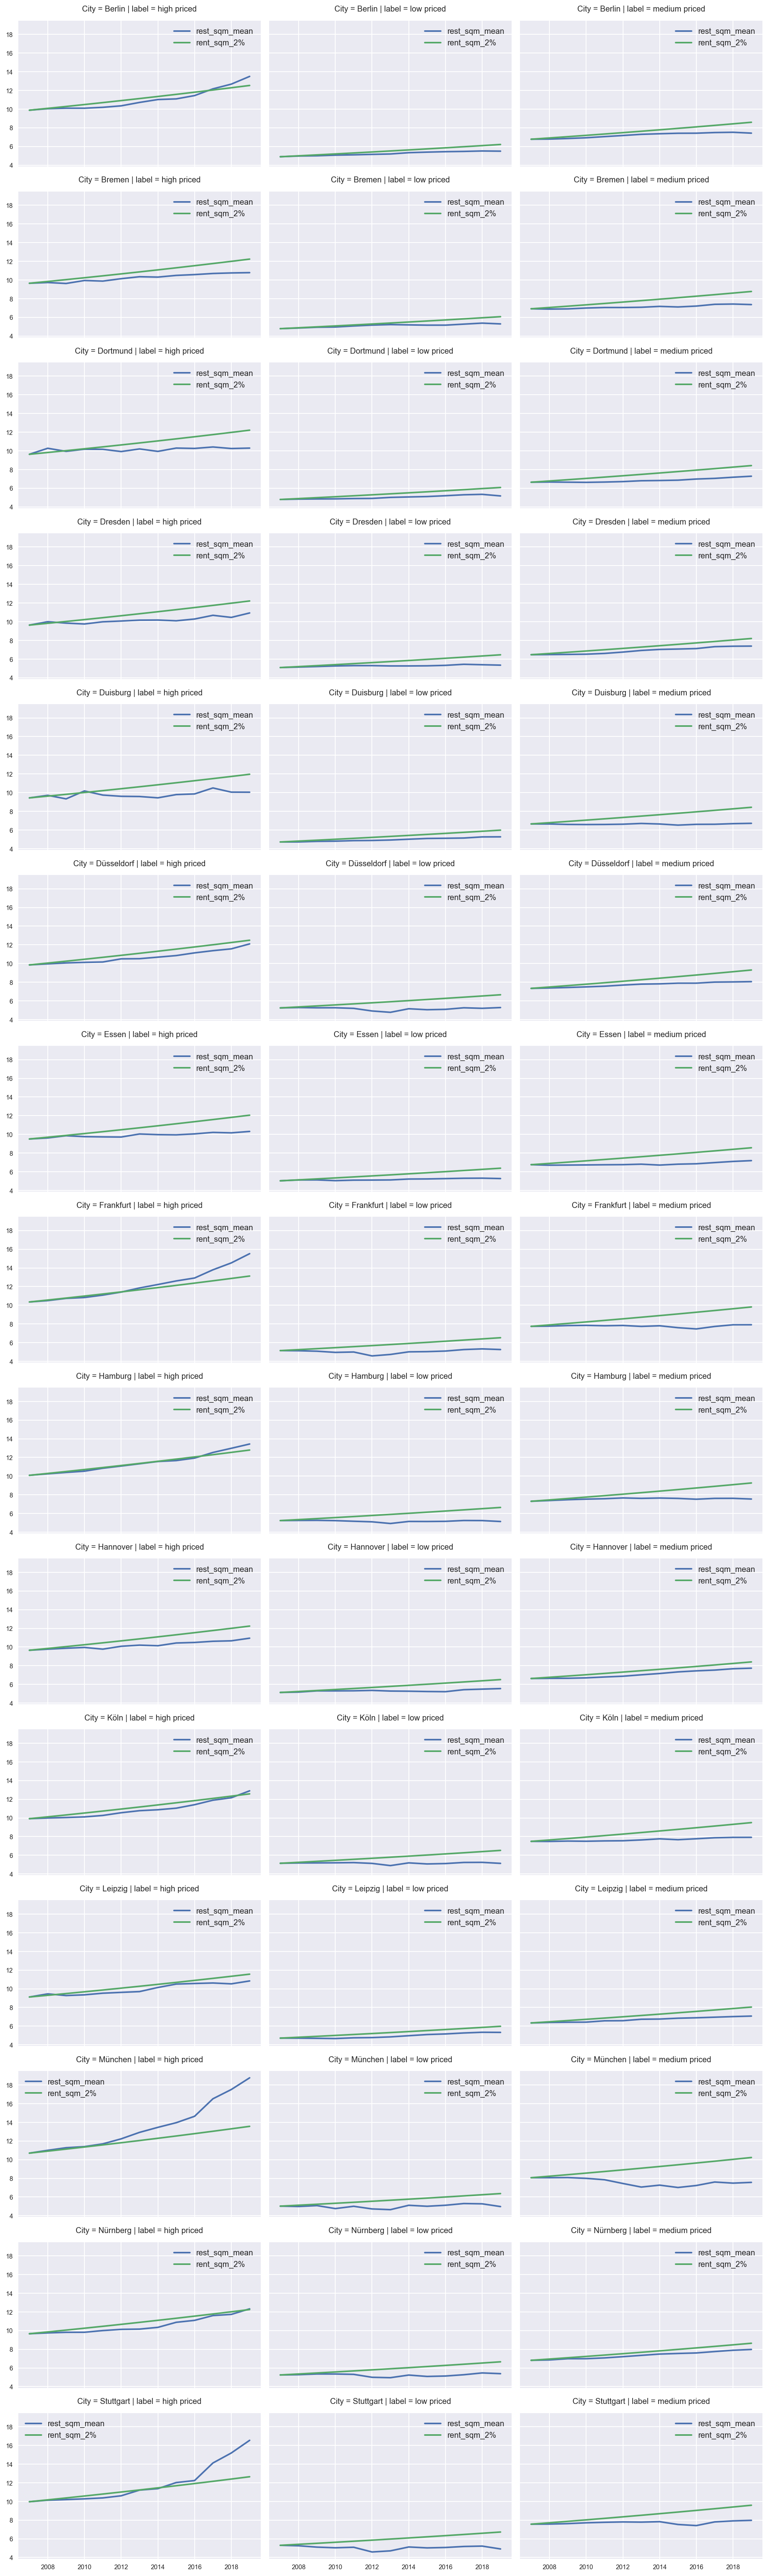

In [326]:
g = sns.FacetGrid(data=rent_sqm_mean_city_year_label, row='City', col='label', height=3, aspect=1.5)
g.map_dataframe(sns.lineplot, x='year', y='value', hue='variable')

for ax in g.axes.ravel():
    ax.legend()



The 2% increase in the low-priced cluster never reaches the level of the medium-priced cluster. And the 2% increase in the medium priced cluster never reaches the level of the high priced cluster.
The clusters are getting smaller and smaller because the rent increases are actually well over 2%.

**Cluster Change Summary**<br>
The clusters change essentially in size over time. Apartments that would have belonged to the cheap apartments a few years ago are rising sharply in price that KMeans has sorted them into a more expensive cluster.

## Part 3: How change the cities over time?


### Mean Rent Increase over time and City

In [327]:
mean_rent_sqm_city = df.groupby(['City', 'year']).rent_sqm.mean().reset_index(name='rent_sqm_mean')
mean_rent_sqm_city = mean_rent_sqm_city.pivot(index='City', columns='year', values='rent_sqm_mean')



In [328]:
## Calculate the change in percent from 2007 to 2019
mean_rent_sqm_city[2019] / mean_rent_sqm_city[2007] * 100 - 100

City
Berlin        111.792455
Bremen         63.129775
Dortmund       49.099668
Dresden        51.344299
Duisburg       24.862916
Düsseldorf     51.287213
Essen          30.840389
Frankfurt      65.262332
Hamburg        64.344993
Hannover       70.353852
Köln           51.779747
Leipzig        57.507064
München        79.062079
Nürnberg       76.758146
Stuttgart      94.172299
dtype: float64

### Display the changes

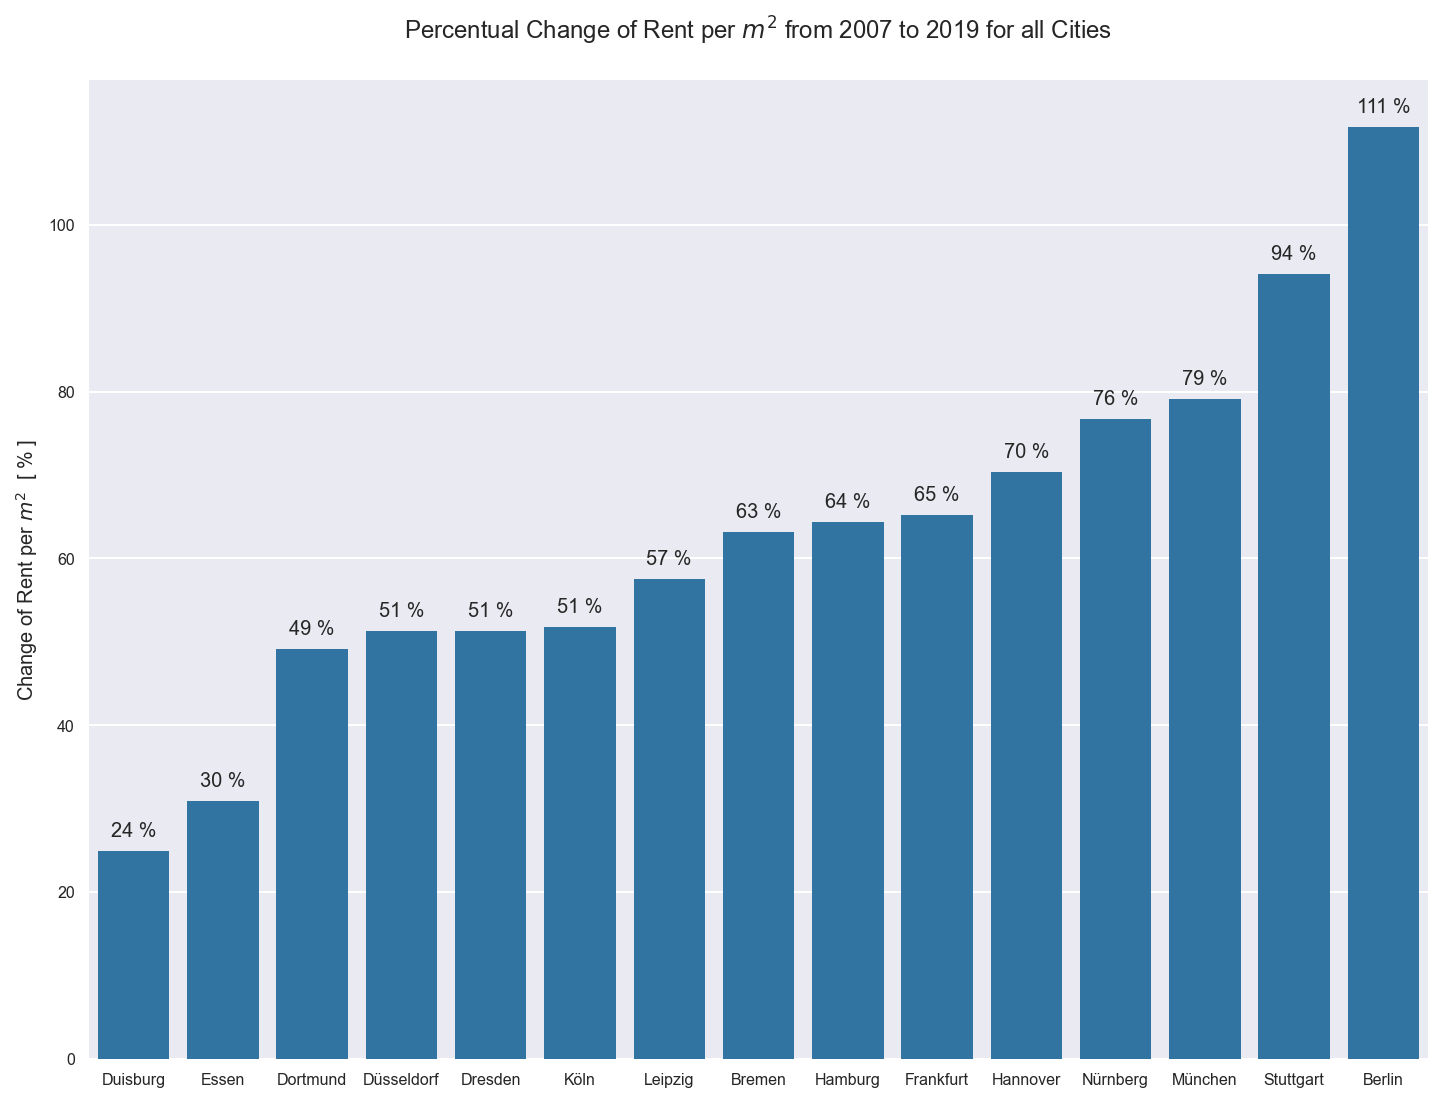

In [97]:
change_df = summary_loss.pivot(index='City', columns='year', values='rent_sqm_mean')
change_df = (change_df[2019] / change_df[2007] * 100 - 100).reset_index(name='change_rent_sqm_mean').sort_values(by='change_rent_sqm_mean', ascending=True)


ax = sns.barplot(data=change_df, x='City', y='change_rent_sqm_mean', color=blue)
plt.title('Percentual Change of Rent per $m^2$ from 2007 to 2019 for all Cities')
plt.xlabel(None)
plt.ylabel('Change of Rent per $m^2$  [ % ]')

for p in ax.patches:
    text = '{} %'.format(int(p.get_height()))
    xy = (p.get_x() + p.get_width() / 2, p.get_y() + p.get_height())
    ax.annotate(text, xy, ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')



#### Calculate some changes between 2007 and 2019

In [333]:
# Aggregate by City rest sqm mean for the years 2007 and 2019
years = [2007, 2019]
summary_rent_2007 = df.query('year == 2007').groupby(['City']).rent_sqm.mean().reset_index(name='rent_sqm_mean').sort_values(by='rent_sqm_mean')
summary_rent_2019 = df.query('year == 2019').groupby(['City']).rent_sqm.mean().reset_index(name='rent_sqm_mean').sort_values(by='rent_sqm_mean')

# Add specific year column
summary_rent_2019['year'] = 2019
summary_rent_2007['year'] = 2007

# Concatenate the dataframes
summary_rent = pd.concat([summary_rent_2019, summary_rent_2007])

**Create Pivot table from 2007 and add 2008 - 2019 calculated by 2% inflation**

In [334]:
summary_rent_2007_pivot = summary_rent_2007.pivot(index='City', columns='year', values='rent_sqm_mean')

    

**Add the calculated 2% columns** 

In [335]:
series = summary_rent_2007_pivot[2007]
for i in range(2007,2019,1):
    series = pd.Series(series*1.02, name=i+1)
    summary_rent_2007_pivot = summary_rent_2007_pivot.join(series)



In [336]:
## extract calculated 2019 2% columns and create Dataframe
inflation_2019 = pd.DataFrame(summary_rent_2007_pivot[2019]).reset_index()
## add column year with value 2019_2%
inflation_2019['year'] = '2019_2%'
## Rename columns
inflation_2019.columns=['City', 'rent_sqm_mean', 'year']
inflation_2019
## add columns to summary_rent
summary_rent = summary_rent.append(inflation_2019)

In [340]:
## Create a pivot table from summary rent
summary_rent_pivot = summary_rent.pivot(index='City', columns='year', values='rent_sqm_mean')
## Create new column from difference 2019 - 2007
summary_rent_pivot['2019 - 2007'] = summary_rent_pivot[2019] - summary_rent_pivot[2007]
## Create new column from 2019_2% - 2007
summary_rent_pivot['2019_2% - 2007'] = summary_rent_pivot['2019_2%'] - summary_rent_pivot[2007]
## Create new column from 2019 - 2019_2%
summary_rent_pivot['Diff'] = summary_rent_pivot['2019 - 2007'] - summary_rent_pivot['2019_2% - 2007']
## Sort values by Diff column
#summary_rent_pivot = summary_rent_pivot.sort_values(by='Diff')
#summary_rent_extended = summary_rent_pivot.reset_index().melt(id_vars='City')
#summary_rent_pivot

**Display Difference between 2007 and 2019**

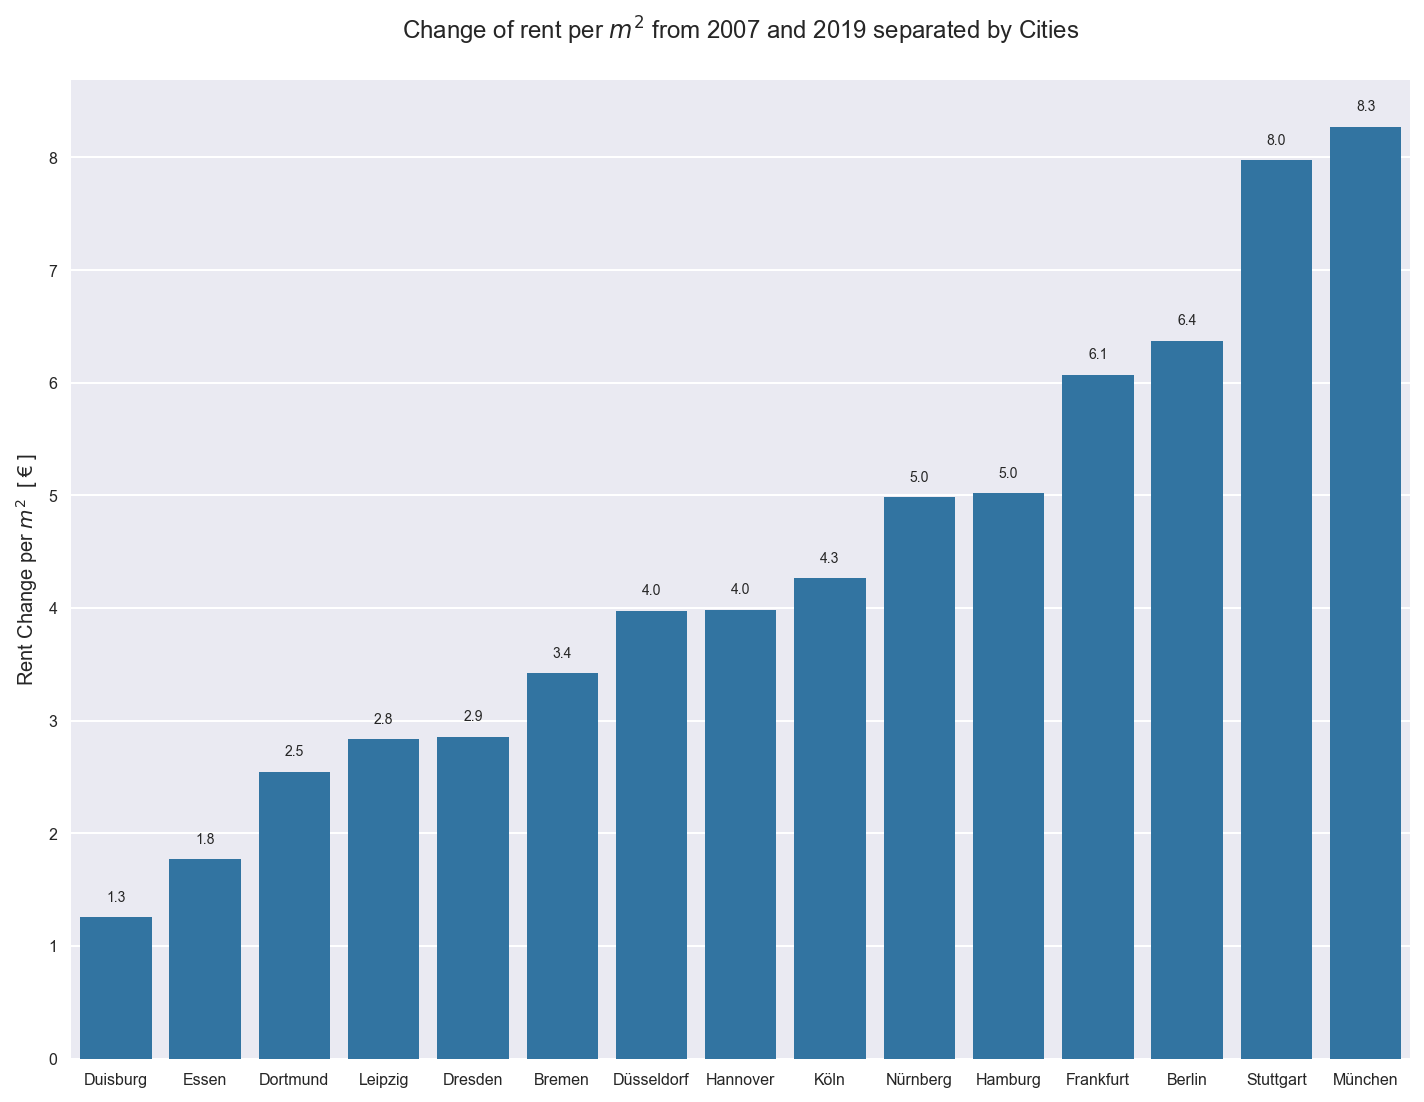

In [341]:
summary_rent_pivot = summary_rent_pivot.sort_values(by='2019 - 2007')
summary_rent_extended = summary_rent_pivot.reset_index().melt(id_vars='City')

ax = sns.barplot(data=summary_rent_extended.query('year=="2019 - 2007"'), x='City', y='value', color=blue)
plt.title('Change of rent per $m^2$ from 2007 and 2019 separated by Cities')

plt.ylabel('Rent Change per $m^2$  [ € ]')
plt.xlabel(None)

for p in ax.patches:
    text = format(p.get_height(), '.1f')
    xy = (p.get_x() + p.get_width() / 2, p.get_y() + p.get_height())
    ax.annotate(text, xy, ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points', size=7)



**Display Difference between 2019 and 2019 in case of 2% inflation**

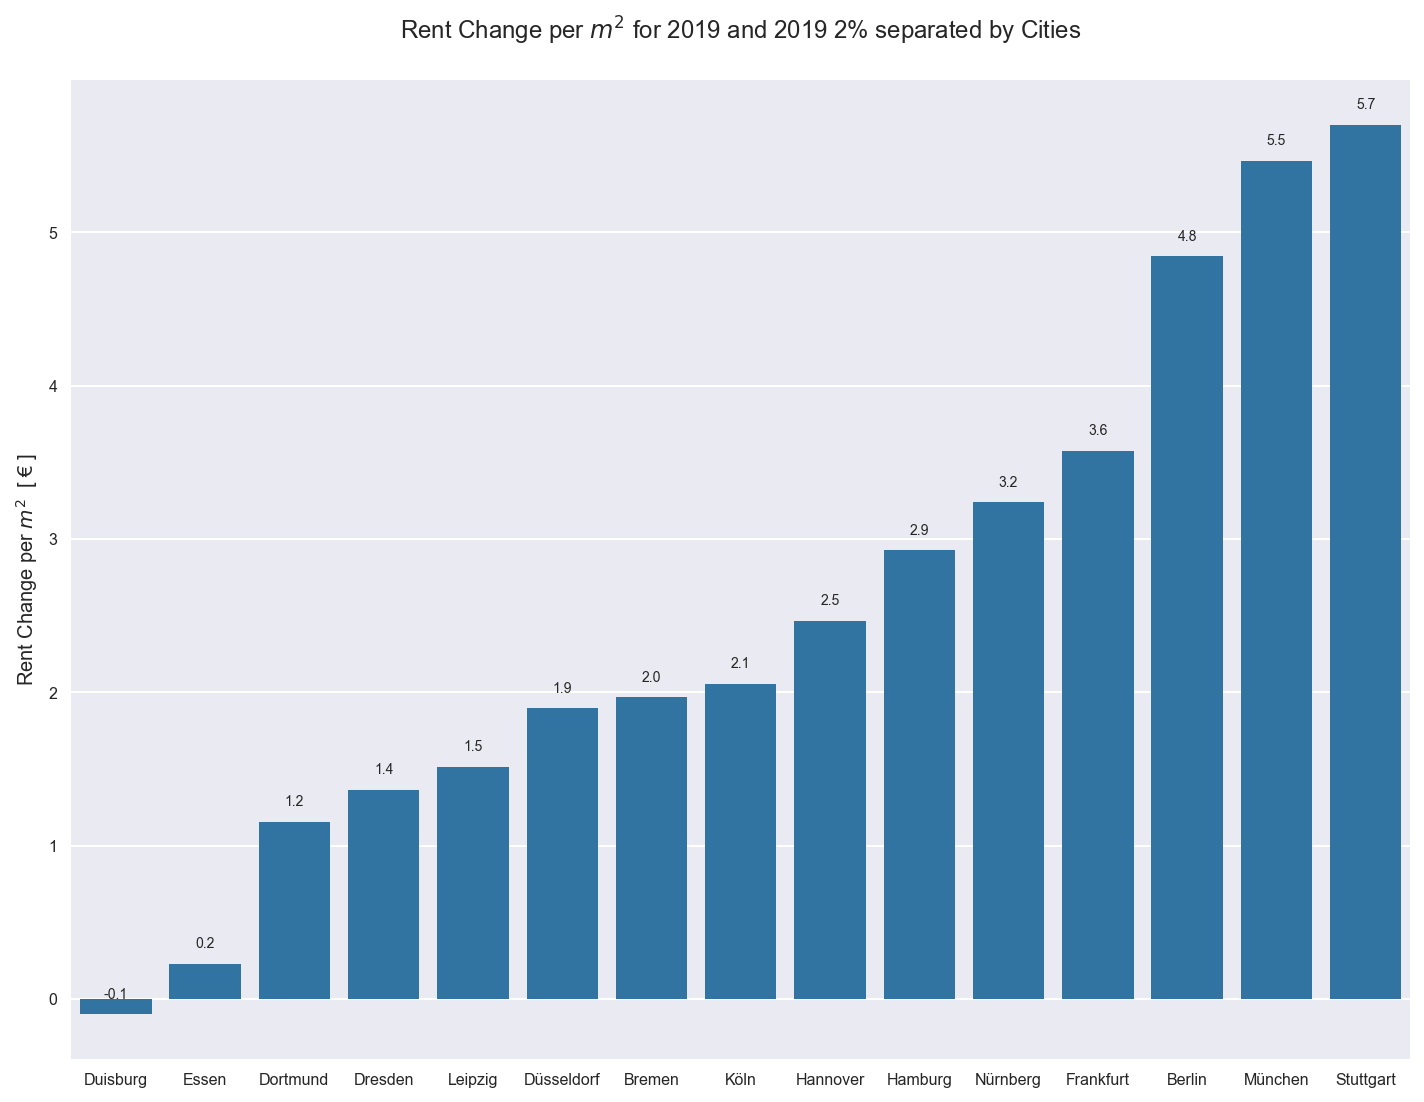

In [344]:
summary_rent_pivot = summary_rent_pivot.sort_values(by='Diff')
summary_rent_extended = summary_rent_pivot.reset_index().melt(id_vars='City')

ax = sns.barplot(data=summary_rent_extended.query('year=="Diff"'), x='City', y='value', color=blue)
plt.title('Rent Change per $m^2$ for 2019 and 2019 2% separated by Cities')
plt.ylabel('Rent Change per $m^2$  [ € ]')
plt.xlabel(None)

for p in ax.patches:
    text = format(p.get_height(), '.1f')
    xy = (p.get_x() + p.get_width() / 2, p.get_y() + p.get_height())
    ax.annotate(text, xy, ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points', size=7)


    

**Display Difference 2007 to 2019 under 2% inflation assumption**

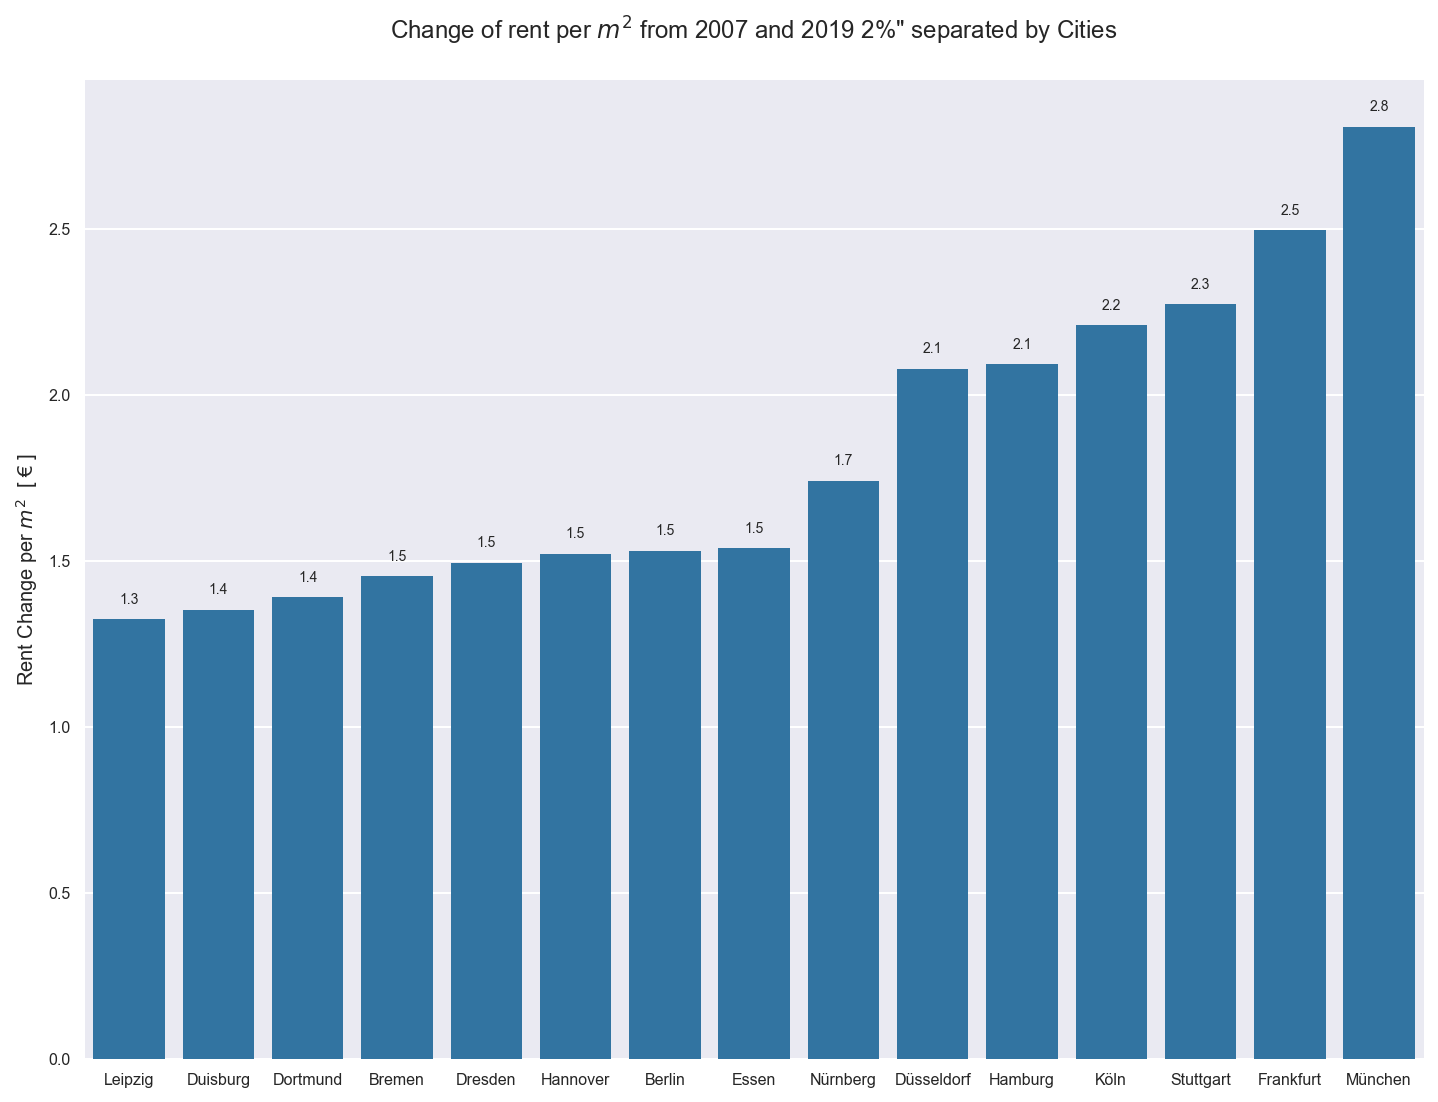

In [345]:
summary_rent_pivot = summary_rent_pivot.sort_values(by='2019_2% - 2007')
summary_rent_extended = summary_rent_pivot.reset_index().melt(id_vars='City')

ax = sns.barplot(data=summary_rent_extended.query('year=="2019_2% - 2007"'), x='City', y='value', color=blue)
plt.title('Change of rent per $m^2$ from 2007 and 2019 2%" separated by Cities')

plt.ylabel('Rent Change per $m^2$  [ € ]')
plt.xlabel(None)

for p in ax.patches:
    text = format(p.get_height(), '.1f')
    xy = (p.get_x() + p.get_width() / 2, p.get_y() + p.get_height())
    ax.annotate(text, xy, ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points', size=7)



**Display some columns together**

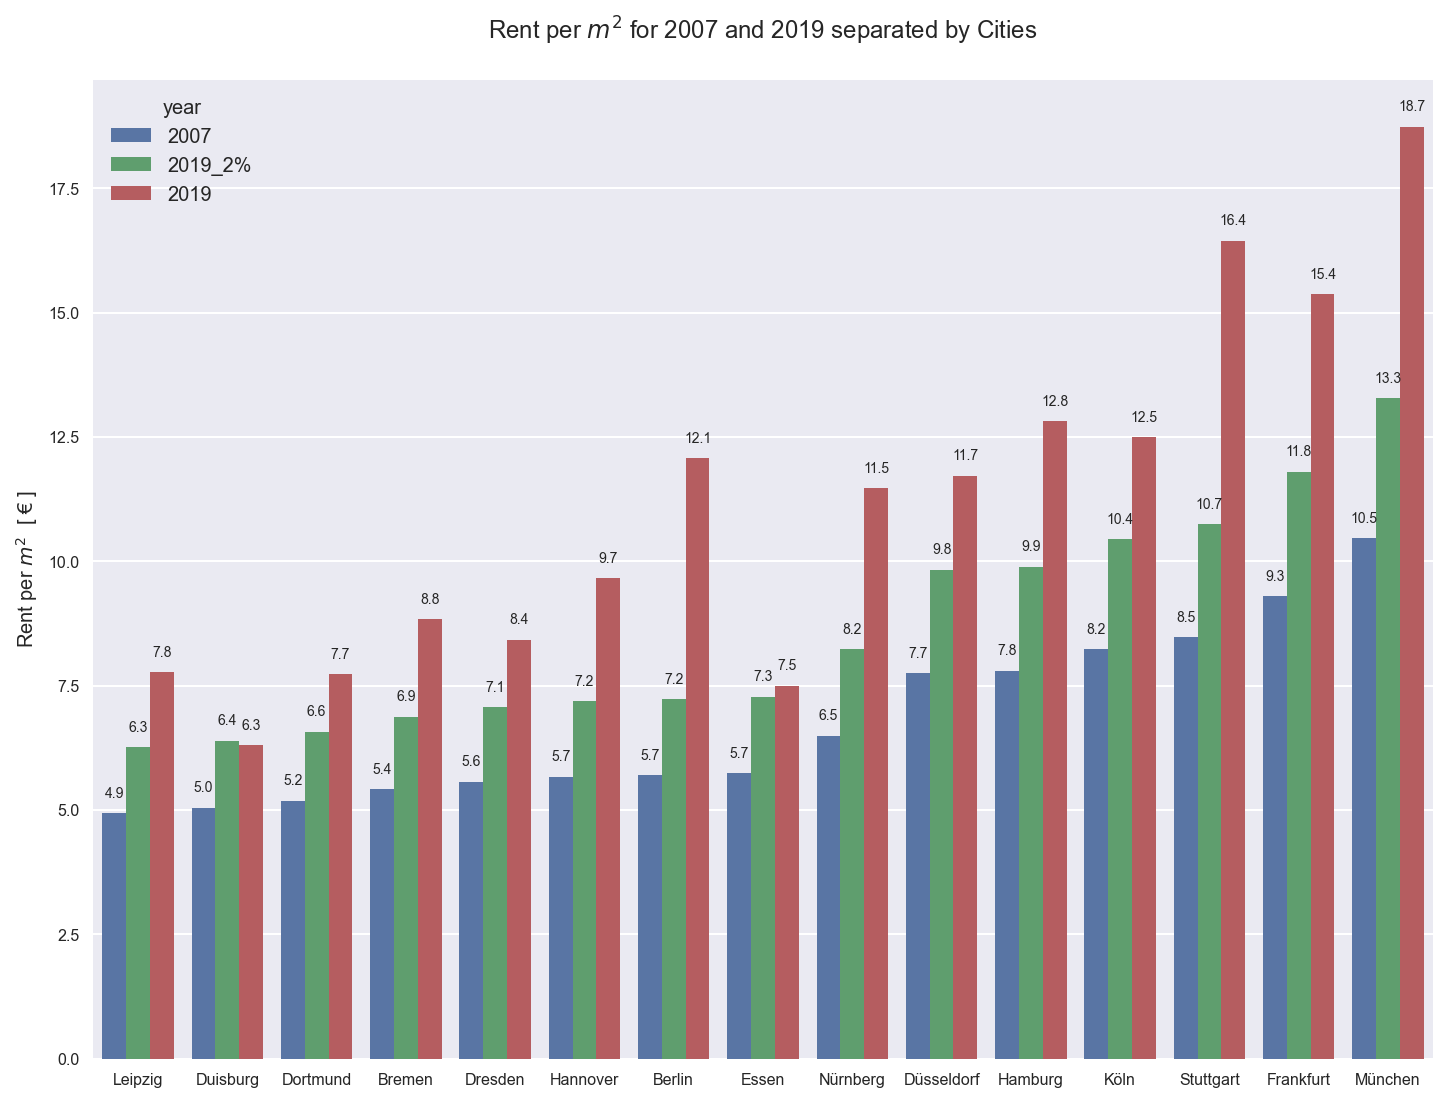

In [110]:
summary_rent_pivot = summary_rent_pivot.sort_values(by=2007)
summary_rent_extended = summary_rent_pivot.reset_index().melt(id_vars='City')

ax = sns.barplot(data=summary_rent_extended, x='City', y='value', hue='year', hue_order=[2007, '2019_2%', 2019])
plt.title('Rent per $m^2$ for 2007 and 2019 separated by Cities')
plt.ylabel('Rent per $m^2$  [ € ]')
plt.xlabel(None)

for p in ax.patches:
    text = format(p.get_height(), '.1f')
    xy = (p.get_x() + p.get_width() / 2, p.get_y() + p.get_height())
    ax.annotate(text, xy, ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points', size=7)

